In [11]:
# Load packages
import numpy as np
import gymnasium as gym
# import torch
import random
import matplotlib.pyplot as plt
from tqdm import trange
import itertools
from typing import List
from itertools import combinations, product

In [12]:
class Fourier_basis:

    def __init__(self, n_states, max_non_zero, p, type_coeffs, defined_coeffs):
        self.n_states = n_states #input size
        self.p = p
        self.max_non_zero = max_non_zero
        self.coeffs = self.define_coeffs(type_coeffs, defined_coeffs) 


    def define_coeffs(self, type_coeffs, defined_coeffs):
        
        if type_coeffs == "predefined":
            coeffs = defined_coeffs
        
        else:
            coeffs = np.array(np.zeros(self.n_states)) 

            for i in range(1, self.max_non_zero + 1):
                for indices in combinations(range(self.n_states), i):
                    for c in product(range(1, self.p + 1), repeat=i):
                        coef = np.zeros(self.n_states)
                        coef[list(indices)] = list(c)
                        coeffs = np.vstack((coeffs, coef))
        
        return coeffs

    def get_phi(self, state): ## to_basis
        return np.cos(np.pi*np.dot(self.coeffs, state))
    
    def scale_learning_rate(self, lr):
        norm = np.linalg.norm(self.coeffs, axis=1)
        norm[norm == 0.] = 1.  # When the norm is zero do not scale
        return lr / norm
    
    def get_num_basis(self):
        """Return the number of basis functions."""
        return self.coeffs.shape[0]



In [23]:
class SarsaLambda:
    def __init__(self, state_space, action_space, min_max_norm=False, alpha=0.0001, lamb=0.9, gamma=0.99, epsilon=0.05, fourier_order=2, max_non_zero_fourier=2, momentum = 0.4, initialization = "zeros", type_coeffs="nothing", defined_coeffs=None, reduction_factor= 1, tau = 1.0, expl_strategy = "e-greedy"):
        # Hyperparameters
        self.alpha = alpha
        self.lamb = lamb
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Environment and state/action spaces
        self.env = gym.make('MountainCar-v0')
        self.state_space = state_space
        self.state_dim = self.state_space.shape[0]
        self.action_space = action_space
        self.action_dim = self.action_space.n

        # Fourier basis
        self.min_max_norm = min_max_norm
        self.p = fourier_order
        self.non_zero = max_non_zero_fourier
        self.basis = Fourier_basis(self.state_dim, self.non_zero, self.p, type_coeffs, defined_coeffs)
        self.scaled_lr = self.basis.scale_learning_rate(self.alpha)
        self.num_basis = self.basis.get_num_basis()

        # Weights and eligibility traces
        self.z = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}

        if initialization == "zeros":
            self.w = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}
        elif initialization == "random uniform":
            low, high = -1.0, 1.0  # Define the range for random initialization
            self.w = {a: np.random.uniform(low, high, self.num_basis) for a in range(self.action_dim)}
        elif initialization == "random gaussian":
            mean, std_dev = 0.0, 1.0
            self.w = {a: np.random.normal(mean, std_dev, self.num_basis) for a in range(self.action_dim)}
        else:
            raise ValueError("Invalid initialization type. Choose from 'zeros', 'random uniform', 'random gaussian', 'ones' or 'noise'.")
     
     
        # Momentum-based SGD variables
        self.velocity = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}
        self.momentum = momentum

        #lr updates
        self.last_threshold = float('-inf')
        self.reduction_factor = reduction_factor

        #exploration
        self.expl_strategy = expl_strategy
        self.tau = tau

    def get_q_value(self, w, action, state):
        """Compute Q-value for a given state and action."""
        return np.dot(w[action], self.basis.get_phi(state))
    

    def get_v_value(self, state):
        """Compute Q-value for a given state and action."""
        return np.max([np.dot(self.w[action], self.basis.get_phi(state)) for action in range(self.action_dim)])
    
    def discretize_state_space(self, n_points=100):
        """
        Discretize the state space into a grid for visualization.

        Args:
            n_points (int): Number of discretization points along each dimension.

        Returns:
            tuple: position_grid, velocity_grid representing the state space grid.
        """
        # Define a grid over the state space
        position_space = np.linspace(self.env.observation_space.low[0], self.env.observation_space.high[0], n_points)
        velocity_space = np.linspace(self.env.observation_space.low[1], self.env.observation_space.high[1], n_points)
        position_grid, velocity_grid = np.meshgrid(position_space, velocity_space)
        
        return position_grid, velocity_grid
    
    
    
    def get_v_function(self, n_points = 100):
        """
        Compute the value function over a discretized state space.

        Args:
            n_points (int): Number of points to discretize along each dimension.

        Returns:
            tuple: position_grid, velocity_grid, v_values representing the value function.
        """
        # Discretize the state space
        position_grid, velocity_grid = self.discretize_state_space(n_points)

        # Compute V-values for each state in the grid
        v_values = np.zeros_like(position_grid)
        for i in range(position_grid.shape[0]):
            for j in range(position_grid.shape[1]):
                state = np.array([position_grid[i, j], velocity_grid[i, j]])
                scaled_state = self.scale_state_variables(state)
                v_values[i, j] = self.get_v_value(scaled_state)

        return position_grid, velocity_grid, v_values




    def get_policy(self, n_points = 100):
        """Compute the optimal policy over the state space."""
    # Discretize the state space
        position_grid, velocity_grid = self.discretize_state_space(n_points)

        # Compute optimal action for each state in the grid
        optimal_policy = np.zeros_like(position_grid, dtype=int)
        for i in range(position_grid.shape[0]):
            for j in range(position_grid.shape[1]):
                state = np.array([position_grid[i, j], velocity_grid[i, j]])
                scaled_state = self.scale_state_variables(state)
                Q_values = [self.get_q_value(self.w, a, scaled_state) for a in range(self.action_dim)]
                optimal_policy[i, j] = np.argmax(Q_values)

        return position_grid, velocity_grid, optimal_policy
            

    # def epsilon_greedy(self, state, test=False):
    #     """Choose action using epsilon-greedy policy."""
    #     if not test and random.random() < self.epsilon:
    #         return np.random.randint(0, self.action_dim)
    #     else:
    #         Q_s = [self.get_q_value(self.w, a, state) for a in range(self.action_dim)]
    #         return np.argmax(Q_s)


    def softmax(self, q_values):
        """Softmax function for action selection."""
        exp_q = np.exp(np.array(q_values) / self.tau) #tau = temperature parameter
        return exp_q / np.sum(exp_q)


    def exploration_strategy(self, state, test=False):
        """Choose action using epsilon-greedy policy."""

        Q_s = [self.get_q_value(self.w, a, state) for a in range(self.action_dim)]

        if self.expl_strategy == "boltzmann":
            probabilities = self.softmax(Q_s)
            return np.random.choice(len(Q_s), p=probabilities)

        else:
            if not test and random.random() < self.epsilon: #exploration
                if self.expl_strategy == "worst":
                    return np.argmin(Q_s)
                elif self.expl_strategy == "state_dep":
                    # inventar-se algo amb posició - velocitat##  return 0, 1 o 2
                    return 0
                else:
                    return np.random.randint(0, self.action_dim)
                
            else: # return best action wrt Q
                return np.argmax(Q_s)

    def update_eligibility_trace(self, action, state):
        """Update eligibility traces."""

        phi_state = self.basis.get_phi(state)
        for a in range(self.action_dim):
            if a == action:
                self.z[a] = self.gamma * self.lamb * self.z[a] + phi_state
            else:
                self.z[a] = self.gamma * self.lamb * self.z[a]

    def update_weights_SGD(self, reward, q, next_q):
        """Update weights using SGD with momentum."""

        delta = reward + self.gamma * next_q - q  # Temporal difference error
        for a in range(self.action_dim):
            self.velocity[a] = self.momentum * self.velocity[a] + self.scaled_lr * delta * self.z[a]
            self.w[a] += self.velocity[a]

    def update_epsilon(self, decay=0.9999): #decay=0.9999
        """Decay epsilon."""
        self.epsilon *= decay

    # def update_learning_rate(self, decay_lr):
    #     """Decay learning rate."""
    #     self.alpha *= decay_lr
    #     self.scaled_lr = self.basis.scale_learning_rate(self.alpha)

    def update_learning_rate(self, avg_reward):
        """
        Reduce learning rate based on average reward thresholds.
        Args:
            avg_reward (float): The average reward over recent episodes.
            reduction_factor (float): Factor by which to reduce the learning rate.
        """
        thresholds = [-140, -135, -130, -125, -120, -115, -110, -105, -100]  # Define thresholds for learning rate reduction

        for threshold in thresholds:
            if avg_reward > threshold > self.last_threshold and self.alpha > 1e-6:  # Avoid reducing alpha below a very small value
                self.alpha *= self.reduction_factor
                self.scaled_lr = self.basis.scale_learning_rate(self.alpha)
                self.last_threshold = threshold
                #print(f"Baixo de {threshold}")
                break  # Apply one reduction at a time to avoid excessive lowering


    def reset_z_v(self):
        """Reset eligibility traces and velocity vectors"""
        for a in range(self.action_dim):
            self.z[a].fill(0.0)
            self.velocity[a].fill(0.0)

    def scale_state_variables(self, s ):
        """Rescale state variables to [0, 1]^n."""
        low=self.env.observation_space.low
        high=self.env.observation_space.high

        return (s - low) / (high - low)

    def sarsa_learning_step(self, state, action, reward, next_state, next_action, done):
        """Perform one step of SARSA(λ)."""
        
        q = self.get_q_value(self.w, action, state)

        if not done:
            next_q = self.get_q_value(self.w, next_action, next_state)
        else:
            next_q = 0.0

        self.update_eligibility_trace(action, state)
        self.update_weights_SGD(reward, q, next_q)
        self.update_epsilon()
        #self.update_learning_rate(self.decay_lr)

        if done:
            self.reset_z_v()


In [14]:
class Trainer:
    def __init__(self, environment: gym.Env,
                 agent: SarsaLambda,
                 epsilon: float = 0.3,
                 number_episodes: int = 200,
                 episode_reward_trigger: float = -135,
                 early_stopping=False
                 ):
        
        ## SET PARAMETERS
        self.early_stopping = early_stopping
        self.episode_reward_trigger = episode_reward_trigger
        self.number_episodes = number_episodes
        self.env = environment
        self.agent = agent
        self.epsilon = epsilon
        #self.reduction_factor = reduction_factor
    

        ## SET VARIABLES
        self.episode_reward_list = []

    # Functions used during training
    def running_average(self, x, N):
        ''' Function used to compute the running mean
            of the last N elements of a vector x
        '''
        if len(x) >= N:
            y = np.copy(x)
            y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
        else:
            y = np.zeros_like(x)
        return y

    def decay_lr(self):
    # Compute average reward over last 30 episodes
        if len(self.episode_reward_list) >= 30:
            avg_reward = np.mean(self.episode_reward_list[-30:])
        else:
            avg_reward = np.mean(self.episode_reward_list)

        # Update learning rate and epsilon
        self.agent.update_learning_rate(avg_reward)

    def train(self):
        #np.random.seed(10)
        ### RESET ENVIRONMENT ###
        self.env.reset() ########

        time = 0

        for e in trange(self.number_episodes):
            done = False
            terminated = False
            state = self.agent.scale_state_variables(self.env.reset()[0])
            total_episode_reward = 0.

            while not (done or terminated):
                ### TAKE ACTION ###
                action = self.agent.exploration_strategy(state)

                ### USE ACTION ###
                next_state, reward, done, terminated, _ = self.env.step(action)
                next_state = self.agent.scale_state_variables(next_state)

                ### COMPUTE NEXT ACTION
                next_action = self.agent.exploration_strategy(next_state)

                ### USE SARSA
                self.agent.sarsa_learning_step(state, action, reward, next_state, next_action, done)

                ## UPDATE DATA
                total_episode_reward += reward
                state = next_state


            self.episode_reward_list.append(total_episode_reward)
            
            #self.agent.update_epsilon()
            self.decay_lr()

            #if e>=30 and self.running_average(self.episode_reward_list, 30)[-1] > self.episode_reward_trigger and self.early_stopping:
            #    break

   
    def test(self, N=50, verbose=False):

        N_EPISODES = N  # Number of episodes to run for trainings
        CONFIDENCE_PASS = -135
        print('Checking solution...')
        EPISODES = trange(N_EPISODES, desc='Episode: ', leave=True)
        episode_reward_list = []
        for i in EPISODES:
            # EPISODES.set_description("Episode {}".format(i))
            # Reset enviroment data
            done = False
            truncated = False
            state = self.agent.scale_state_variables(self.env.reset()[0])
            total_episode_reward = 0.

            action = self.agent.exploration_strategy(state, test=True)

            while not (done or truncated):
                # Get next state and reward.  The done variable
                # will be True if you reached the goal position,
                # False otherwise
                next_state, reward, done, truncated, *_ = self.env.step(action)
                next_state = self.agent.scale_state_variables(next_state)
                next_action = self.agent.exploration_strategy(state, test=True)

                # Update episode reward
                total_episode_reward += reward

                # Update state for next iteration
                state = next_state
                action = next_action

            # Append episode reward
            episode_reward_list.append(total_episode_reward)

            # Close environment
            self.env.close()

        avg_reward = np.mean(episode_reward_list)
        confidence = np.std(episode_reward_list) * 1.96 / np.sqrt(N_EPISODES)

        if verbose:
            print('Policy achieves an average total reward of {:.1f} +/- {:.1f} with confidence 95%.'.format(
                avg_reward,
                confidence))

        if avg_reward - confidence >= CONFIDENCE_PASS:
            if verbose:
                print('Your policy passed the test!')
            return True, avg_reward, confidence
        else:
            if verbose:
                print(
                    'Your policy did not pass the test! The average reward of your policy needs to be greater than {} with 95% confidence'.format(
                        CONFIDENCE_PASS))
            return False, avg_reward, confidence

            

In [15]:
predefined_coeff_matrix_1 = np.array([
                [1, 0],
                [0, 1]
                ])


predefined_coeff_matrix_2 = np.array([
                [0, 1],
                [1, 0],
                [1, 1],
                ])

predefined_coeff_matrix_3 = np.array([
                [0, 0],
                [0, 1],
                [1, 0],
                [1, 1],
                ])

predefined_coeff_matrix_4 = np.array([
                [0, 1],
                [0, 2],
                [1, 0],
                [1, 1],
                [1, 2],
                [2, 0],
                [2, 1],
                [2, 2]
                ])

predefined_coeff_matrix_5 = np.array([
                [0, 0],
                [0, 1],
                [0, 2],
                [1, 0],
                [1, 1],
                [1, 2],
                [2, 0],
                [2, 1],
                [2, 2],
                ]) ##this is the same we get if we use default basis (max_non_zero = 2)

In [16]:
def plot_smoothed_rewards(rewards, window_size=20):
    """
    Plots smoothed rewards using a moving average.

    Parameters:
        rewards (list or np.array): The list of rewards for each episode.
        window_size (int): The size of the sliding window for averaging. Default is 20.
    """
    # Compute the moving average
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    
    # Plot the results
    plt.plot(smoothed_rewards)
    plt.title(f"Smoothed Episode Rewards (Window Size: {window_size})")
    plt.xlabel("Episodes")
    plt.ylabel("Smoothed Total Reward")
    plt.show()

In [17]:
# def compute_smoothed_rewards(rewards, window_size=20):
#     """Compute smoothed rewards using a moving average."""

#     rewards = [-200 for i in range(window_size)] + rewards

#     smoothed = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
#     std_devs = [
#         np.std(rewards[max(0, i - window_size + 1):i + 1])
#         for i in range(len(smoothed))
#     ]
#     return smoothed, np.array(std_devs)

# def plot_smoothed_rewards_with_confidence(rewards, cf,window_size=20, label=None, color = 'blue'):
#     """Plot smoothed rewards with confidence intervals."""

    
#     smoothed_rewards, std_devs = compute_smoothed_rewards(rewards, window_size)
#     x_vals = np.arange(len(smoothed_rewards))
#     plt.plot(x_vals, smoothed_rewards, label=label, color = color)
#     if cf:
#         plt.fill_between(
#             x_vals,
#             smoothed_rewards - std_devs,
#             smoothed_rewards + std_devs,
#             alpha=0.3
#         )
#         plt.title("Smoothed Rewards with Confidence Interval")
#     else:
#         plt.title("Smoothed Rewards depending on the coefficients of the Fourier Basis")
#     plt.xlabel("Episodes")
#     plt.ylabel("Smoothed Reward")
#     plt.ylim((-200,-110))
    
#     if label:
#         plt.legend(loc='upper left')

# def plot_all_smoothed_rewards(all_rewards, window_size=20, labels=None, cf = True):
#     """Plot smoothed rewards with confidence intervals for all attempts."""
#     plt.figure(figsize=(12, 6)) 
#     colors = ['red', 'purple']
#     for i, rewards in enumerate(all_rewards):
#         label = labels[i] if labels else None
#         color = colors[i]
#         plot_smoothed_rewards_with_confidence(rewards,cf, window_size, label, color)
#     plt.show()

In [18]:
def compute_smoothed_rewards(rewards, window_size=20):
    """Compute smoothed rewards using a moving average."""

    rewards = [-200 for i in range(window_size)] + rewards

    smoothed = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
    std_devs = [
        np.std(rewards[max(0, i - window_size + 1):i + 1])
        for i in range(len(smoothed))
    ]
    return smoothed, np.array(std_devs)

def plot_smoothed_rewards_with_confidence(rewards, cf,window_size=20, label=None):
    """Plot smoothed rewards with confidence intervals."""

    
    smoothed_rewards, std_devs = compute_smoothed_rewards(rewards, window_size)
    x_vals = np.arange(len(smoothed_rewards))
    plt.plot(x_vals, smoothed_rewards, label=label)
    if cf:
        plt.fill_between(
            x_vals,
            smoothed_rewards - std_devs,
            smoothed_rewards + std_devs,
            alpha=0.3
        )
        plt.title(r"Smoothed Rewards with Confidence Interval depending on the initialization of the Q-values")
    else:
        plt.title(r"Smoothed Rewards depending on the initialization of the Q-values")
    plt.xlabel("Episodes")
    plt.ylabel("Smoothed Reward")
    
    if label:
        plt.legend()

def plot_all_smoothed_rewards(all_rewards, window_size=20, labels=None, cf = True):
    """Plot smoothed rewards with confidence intervals """
    plt.figure(figsize=(12, 6)) 
    for i, rewards in enumerate(all_rewards):
        label = labels[i] if labels else None
        plot_smoothed_rewards_with_confidence(rewards,cf, window_size, label)
    plt.show()

In [19]:
def run_hyperparameter_search(hyperparameters, num_episodes=200, test_episodes=50, early_stopping=True):
    """
    Run a hyperparameter search for a SARSA(λ) agent on the MountainCar-v0 environment.

    Args:
        hyperparameters (dict): Dictionary of hyperparameters. Keys with lists will be treated as variable.
        num_episodes (int): Number of episodes to train.
        test_episodes (int): Number of episodes to test.
        early_stopping (bool): Whether to use early stopping during training.
    
    Returns:
        tuple: (all_rewards, all_labels)
            all_rewards (list of lists): Episode rewards for each hyperparameter combination.
            all_labels (list of str): Labels describing each hyperparameter combination.
    """
    # Separate fixed and variable hyperparameters
    fixed_hyperparams = {k: v for k, v in hyperparameters.items() if not isinstance(v, list)}
    variable_hyperparams = {k: v for k, v in hyperparameters.items() if isinstance(v, list)}

    # Generate all combinations of variable hyperparameters
    keys, values = zip(*variable_hyperparams.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # Initialize lists to store results
    all_rewards = []
    all_labels = []

    test_avg_rewards = []
    test_confidences = []

    # Loop over all hyperparameter combinations
    for i, params in enumerate(param_combinations):
        # Combine fixed and variable hyperparameters
        current_hyperparams = {**fixed_hyperparams, **params}

        # Extract hyperparameters for this iteration
        alpha = current_hyperparams["alpha"]
        lamb = current_hyperparams["λ"]
        gamma = current_hyperparams["gamma"]
        epsilon = current_hyperparams["epsilon"]
        fourier_order = current_hyperparams["fourier_order"]
        max_non_zero_fourier = current_hyperparams["max_non_zero_fourier"]
        reduction_factor = current_hyperparams["reduction factor"]
        initialization = current_hyperparams["initialization"]
        expl_strategy = current_hyperparams["expl_strategy"]
        type_coeffs = current_hyperparams["type_coeffs"]
        defined_coeffs = current_hyperparams["defined_coeffs"]

        # Initialize environment
        env = gym.make("MountainCar-v0")

        # Initialize SARSA(λ) agent
        agent = SarsaLambda(
            state_space=env.observation_space,
            action_space=env.action_space,
            alpha=alpha,
            lamb=lamb,
            gamma=gamma,
            epsilon=epsilon,
            fourier_order=fourier_order,
            max_non_zero_fourier=max_non_zero_fourier,
            reduction_factor=reduction_factor,
            initialization=initialization,
            expl_strategy=expl_strategy,
            type_coeffs=type_coeffs,
            defined_coeffs=defined_coeffs
        )

        # Initialize trainer
        trainer = Trainer(
            environment=env,
            agent=agent,
            epsilon=epsilon,
            number_episodes=num_episodes,
            episode_reward_trigger=-150,
            early_stopping=early_stopping,
        )

        # Train and test the agent
        print(f"Starting training for combination {i + 1}/{len(param_combinations)}: {current_hyperparams}")
        trainer.train()
        print(f"Training for combination {i + 1} completed!")
        _, avg_reward, confidence = trainer.test(N=test_episodes, verbose=True)
        test_avg_rewards.append(avg_reward)
        test_confidences.append(confidence)
        print(f"Testing for combination {i + 1} completed!")

        # Store results
        all_rewards.append(trainer.episode_reward_list)
        
        # Create label only for variable hyperparameters
        variable_label = ", ".join(f"{k}={params[k]}" for k in variable_hyperparams)
        all_labels.append(variable_label)

        # Close environment
        env.close()


    return all_rewards, all_labels, test_avg_rewards, test_confidences

Starting training for combination 1/5: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'predefined', 'defined_coeffs': array([[1, 0],
       [0, 1]])}


100%|██████████| 500/500 [00:10<00:00, 46.98it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 119.12it/s]


Policy achieves an average total reward of -171.1 +/- 9.4 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/5: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'predefined', 'defined_coeffs': array([[0, 1],
       [1, 0],
       [1, 1]])}


100%|██████████| 500/500 [00:08<00:00, 55.62it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 150.55it/s]


Policy achieves an average total reward of -139.0 +/- 10.6 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/5: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'predefined', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])}


100%|██████████| 500/500 [00:08<00:00, 56.59it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 150.60it/s]


Policy achieves an average total reward of -141.1 +/- 10.2 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 4/5: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'predefined', 'defined_coeffs': array([[0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])}


100%|██████████| 500/500 [00:07<00:00, 65.35it/s]


Training for combination 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 150.70it/s]


Policy achieves an average total reward of -140.3 +/- 7.6 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 4 completed!
Starting training for combination 5/5: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'predefined', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])}


100%|██████████| 500/500 [00:06<00:00, 73.14it/s]


Training for combination 5 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 164.88it/s]


Policy achieves an average total reward of -129.0 +/- 5.4 with confidence 95%.
Your policy passed the test!
Testing for combination 5 completed!


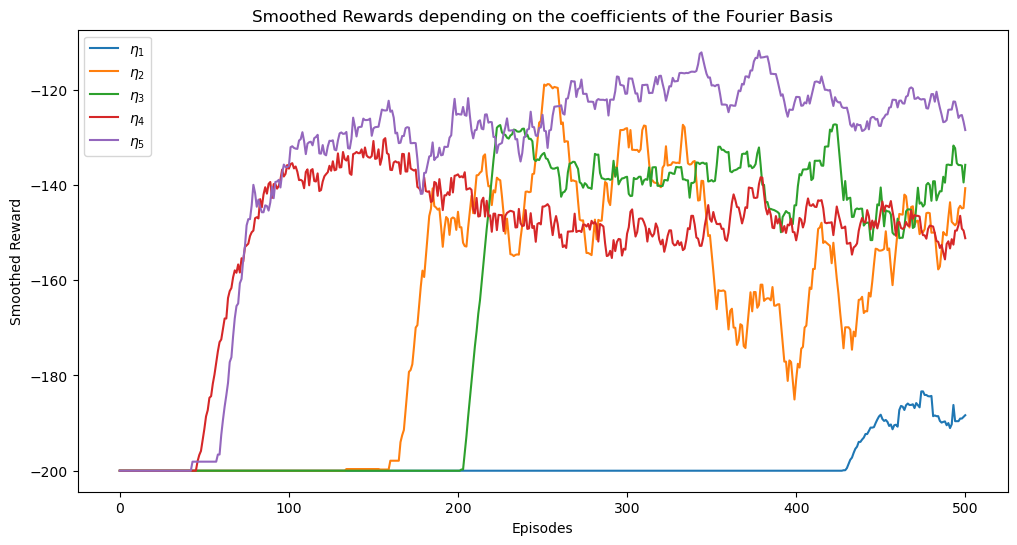

In [38]:
if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "lamb": 0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction_factor": 1,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "predefined", 
        "defined_coeffs": [predefined_coeff_matrix_1, predefined_coeff_matrix_2, predefined_coeff_matrix_3, predefined_coeff_matrix_4, predefined_coeff_matrix_5],
    }

    # Run the hyperparameter search
    all_rewards, all_labels = run_hyperparameter_search(hyperparameters, num_episodes=500, test_episodes=50)

    labels = [r'$\eta_1$', '$\eta_2$', '$\eta_3$', '$\eta_4$', '$\eta_5$']
    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=20, labels=labels, cf=False)


Starting training for combination 1/2: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'predefined', 'defined_coeffs': array([[0, 1],
       [1, 0],
       [1, 1]])}


100%|██████████| 500/500 [00:08<00:00, 60.50it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 143.36it/s]


Policy achieves an average total reward of -151.5 +/- 11.2 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/2: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'predefined', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])}


100%|██████████| 500/500 [00:08<00:00, 62.50it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 109.55it/s]


Policy achieves an average total reward of -195.4 +/- 4.3 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!


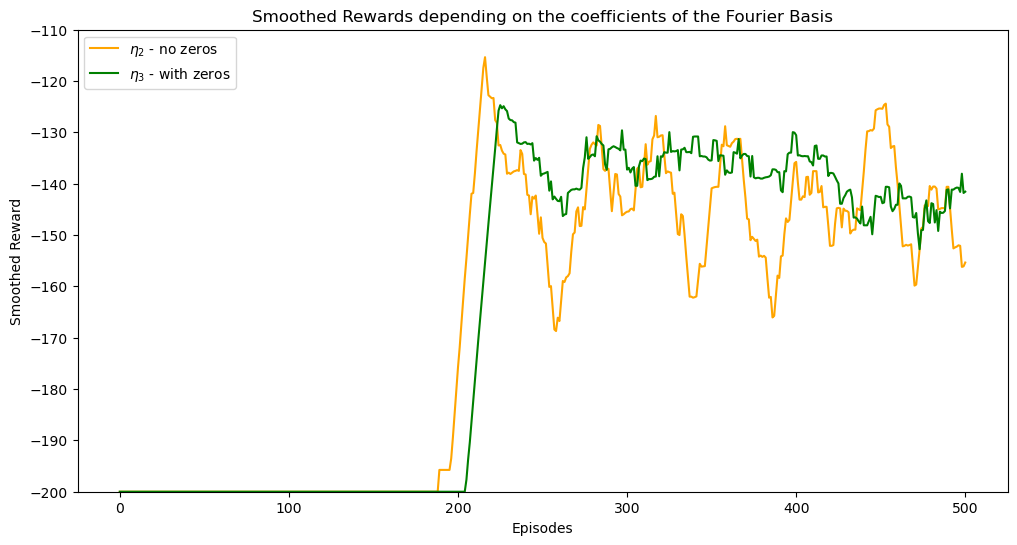

In [61]:
if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "lamb": 0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction_factor": 1,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "predefined", 
        "defined_coeffs": [ predefined_coeff_matrix_2, predefined_coeff_matrix_3],
    }

    # Run the hyperparameter search
    all_rewards, all_labels = run_hyperparameter_search(hyperparameters, num_episodes=500, test_episodes=50)

    labels = [r'$\eta_2$ - no zeros', '$\eta_3$ - with zeros']
    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=20, labels=labels, cf=False)


Starting training for combination 1/2: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'predefined', 'defined_coeffs': array([[0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])}


100%|██████████| 500/500 [00:07<00:00, 64.43it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 155.21it/s]


Policy achieves an average total reward of -129.2 +/- 6.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/2: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'predefined', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]])}


100%|██████████| 500/500 [00:06<00:00, 74.51it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 165.27it/s]


Policy achieves an average total reward of -127.4 +/- 4.6 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!


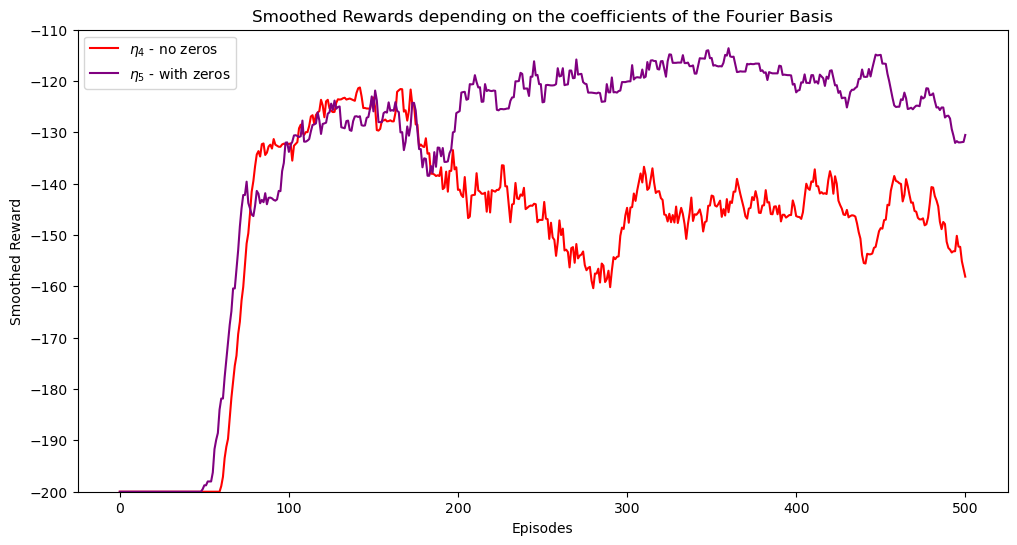

In [65]:
if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "lamb": 0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction_factor": 1,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "predefined", 
        "defined_coeffs": [predefined_coeff_matrix_4, predefined_coeff_matrix_5],
    }

    # Run the hyperparameter search
    all_rewards, all_labels = run_hyperparameter_search(hyperparameters, num_episodes=500, test_episodes=50)

    labels = [r'$\eta_4$ - no zeros', '$\eta_5$ - with zeros']
    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=20, labels=labels, cf=False)


Starting training for combination 1/4: {'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'alpha': 0.0001}


100%|██████████| 500/500 [00:09<00:00, 50.93it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 120.09it/s]


Policy achieves an average total reward of -178.3 +/- 6.7 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/4: {'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'alpha': 0.001}


100%|██████████| 500/500 [00:06<00:00, 76.22it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 155.46it/s]


Policy achieves an average total reward of -136.2 +/- 7.4 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/4: {'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'alpha': 0.01}


100%|██████████| 500/500 [00:08<00:00, 58.30it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 106.37it/s]


Policy achieves an average total reward of -195.6 +/- 1.3 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 4/4: {'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 1, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'alpha': 0.1}


100%|██████████| 500/500 [00:10<00:00, 49.47it/s]


Training for combination 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 106.55it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 4 completed!


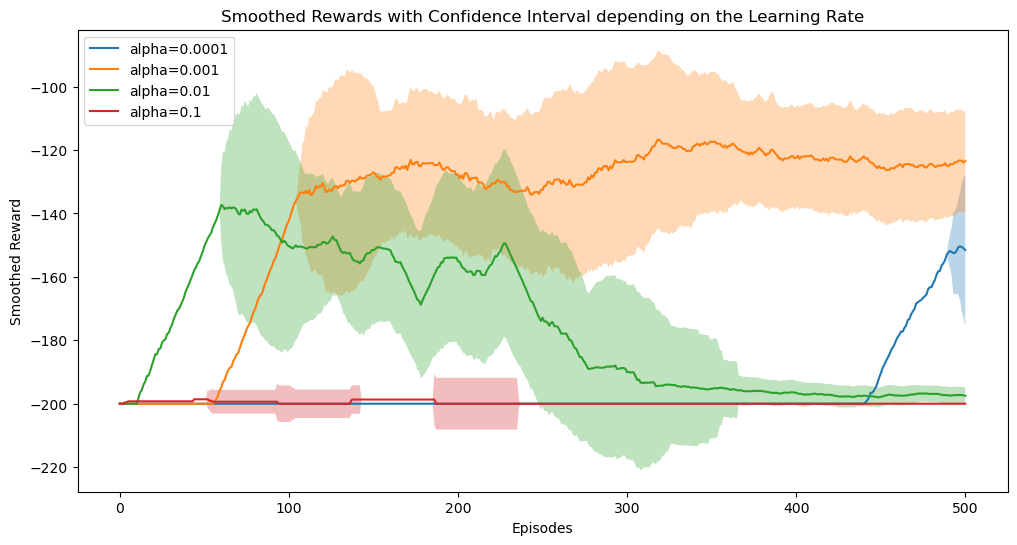

In [75]:


if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": [0.0001, 0.001, 0.01, 0.1],  # Learning rate
        "lamb": 0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction_factor": 1,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "nothing", 
        "defined_coeffs":  predefined_coeff_matrix_5,
    }

    # Run the hyperparameter search
    all_rewards, all_labels = run_hyperparameter_search(hyperparameters, num_episodes=500, test_episodes=50)
   
    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=True)


In [11]:
def plot_test_results(test_avg_rewards, test_confidences, values):
    fig = plt.figure(figsize=(10, 6))
    plt.errorbar(values, test_avg_rewards, yerr=test_confidences, fmt='o-', capsize=5, label='Mean Reward ± Std Dev')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Average Reward')
    plt.xscale('log')
    plt.title(f'Effect of the Learning Rate on Performance')
    plt.legend()
    plt.grid()
    plt.show()



Starting training for combination 1/4: {'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'alpha': 0.0001}


100%|██████████| 300/300 [00:06<00:00, 48.36it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 107.51it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/4: {'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'alpha': 0.001}


100%|██████████| 300/300 [00:04<00:00, 72.60it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 180.44it/s]


Policy achieves an average total reward of -120.7 +/- 3.6 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/4: {'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'alpha': 0.01}


100%|██████████| 300/300 [00:04<00:00, 68.00it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 138.86it/s]


Policy achieves an average total reward of -150.3 +/- 6.6 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 4/4: {'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'alpha': 0.1}


100%|██████████| 300/300 [00:05<00:00, 51.52it/s]


Training for combination 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 107.51it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 4 completed!


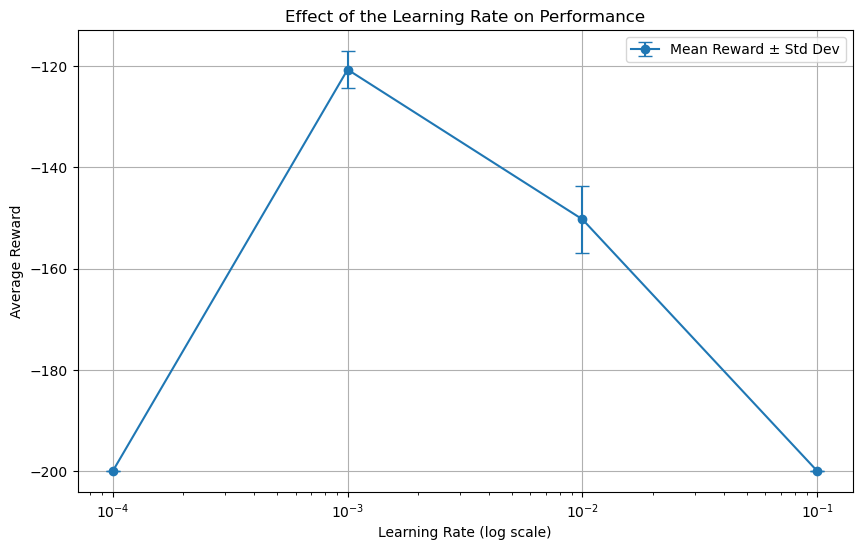

In [23]:
if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": [0.0001, 0.001, 0.01, 0.1],  # Learning rate
        "λ": 0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction factor": 0.7,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "nothing", 
        "defined_coeffs":  predefined_coeff_matrix_5,
    }

    # Run the hyperparameter search
    all_rewards, all_labels, test_avg_rewards, test_confidences = run_hyperparameter_search(hyperparameters, num_episodes=300, test_episodes=50)
   
    # Plot results
    #plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=False)
    plot_test_results(test_avg_rewards, test_confidences, [0.0001, 0.001, 0.01, 0.1])


Starting training for combination 1/4: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'reduction factor': 1}


100%|██████████| 275/275 [00:04<00:00, 64.33it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 177.51it/s]


Policy achieves an average total reward of -119.3 +/- 4.7 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/4: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'reduction factor': 0.7}


100%|██████████| 275/275 [00:04<00:00, 66.77it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 186.62it/s]


Policy achieves an average total reward of -115.6 +/- 2.0 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/4: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'reduction factor': 0.5}


100%|██████████| 275/275 [00:03<00:00, 69.26it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 166.68it/s]


Policy achieves an average total reward of -125.6 +/- 5.6 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 4/4: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'reduction factor': 0.3}


100%|██████████| 275/275 [00:04<00:00, 65.47it/s]


Training for combination 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 143.67it/s]


Policy achieves an average total reward of -137.5 +/- 5.9 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 4 completed!


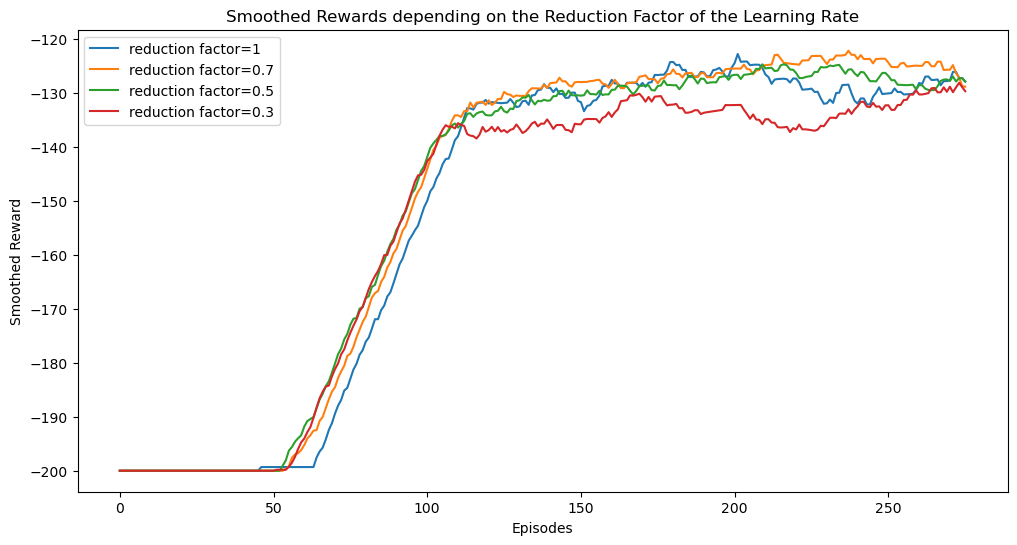

In [92]:


if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "lamb": 0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction factor": [1,0.7, 0.5,0.3],  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "nothing", 
        "defined_coeffs":  predefined_coeff_matrix_5,
    }

    # Run the hyperparameter search
    all_rewards, all_labels = run_hyperparameter_search(hyperparameters, num_episodes=275, test_episodes=50)
   
    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=False)


Starting training for combination 1/4: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'reduction factor': 1}


100%|██████████| 275/275 [00:04<00:00, 66.81it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 177.39it/s]


Policy achieves an average total reward of -116.9 +/- 4.1 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/4: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'reduction factor': 0.7}


100%|██████████| 275/275 [00:03<00:00, 69.30it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 178.82it/s]


Policy achieves an average total reward of -119.1 +/- 4.1 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/4: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'reduction factor': 0.5}


100%|██████████| 275/275 [00:03<00:00, 68.98it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 158.86it/s]


Policy achieves an average total reward of -132.5 +/- 6.5 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 4/4: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'reduction factor': 0.3}


100%|██████████| 275/275 [00:04<00:00, 66.31it/s]


Training for combination 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 139.97it/s]


Policy achieves an average total reward of -132.6 +/- 7.2 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 4 completed!


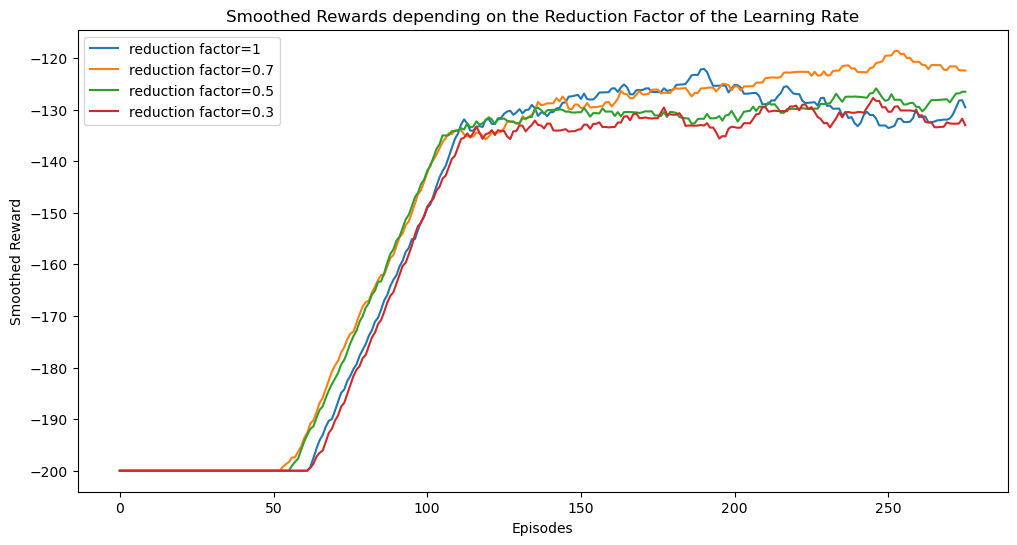

In [100]:


if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "lamb": 0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction factor": [1,0.7, 0.5,0.3],  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "nothing", 
        "defined_coeffs":  predefined_coeff_matrix_5,
    }

    # Run the hyperparameter search
    all_rewards, all_labels = run_hyperparameter_search(hyperparameters, num_episodes=275, test_episodes=50)
   
    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=False)


Starting training for combination 1/5: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 1}


100%|██████████| 300/300 [00:06<00:00, 43.35it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 108.17it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/5: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.8}


100%|██████████| 300/300 [00:03<00:00, 75.30it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 154.78it/s]


Policy achieves an average total reward of -118.7 +/- 4.8 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/5: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.6}


100%|██████████| 300/300 [00:04<00:00, 74.57it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 188.23it/s]


Policy achieves an average total reward of -118.7 +/- 3.6 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 4/5: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.4}


100%|██████████| 300/300 [00:04<00:00, 70.19it/s]


Training for combination 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 175.56it/s]


Policy achieves an average total reward of -124.4 +/- 3.4 with confidence 95%.
Your policy passed the test!
Testing for combination 4 completed!
Starting training for combination 5/5: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0}


100%|██████████| 300/300 [00:04<00:00, 61.75it/s]


Training for combination 5 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 177.10it/s]


Policy achieves an average total reward of -123.2 +/- 2.0 with confidence 95%.
Your policy passed the test!
Testing for combination 5 completed!


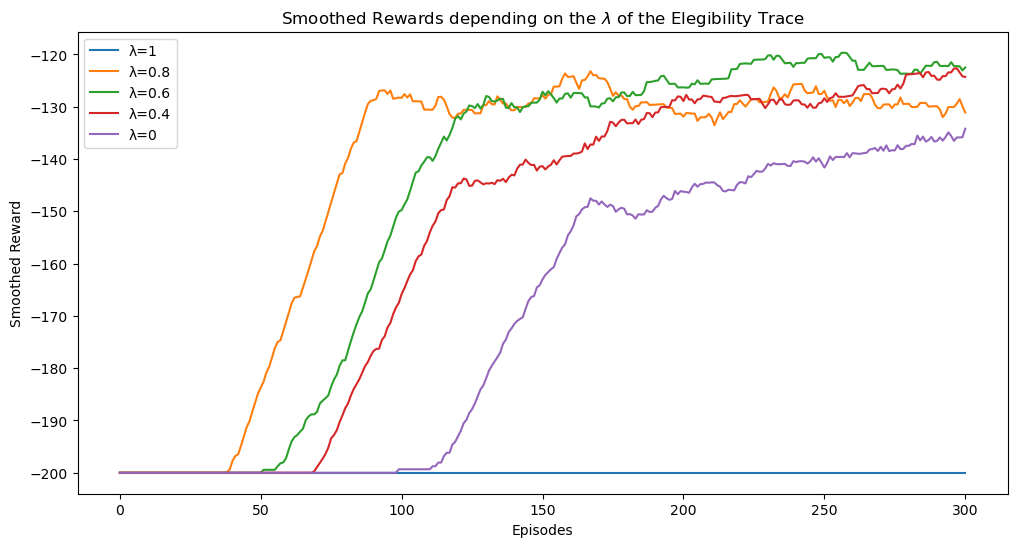

In [20]:


if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "λ": [1, 0.8, 0.6, 0.4, 0],      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction factor": 0.7,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "nothing", 
        "defined_coeffs":  predefined_coeff_matrix_5,
    }

    # Run the hyperparameter search
    all_rewards, all_labels = run_hyperparameter_search(hyperparameters, num_episodes=300, test_episodes=50)
   
    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=False)


In [1]:
def plot_test_results(test_avg_rewards, test_confidences, values):
    plt.figure(figsize=(10, 6))
    plt.errorbar(values, test_avg_rewards, yerr=test_confidences, fmt='o-', capsize=5, label='Mean Reward ± Std Dev')
    plt.xlabel('Lambda')
    plt.ylabel('Average Reward')
    plt.title(f'Effect of Lambda on Performance')
    plt.legend()
    plt.grid()
    plt.show()



Starting training for combination 1/4: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.8}


100%|██████████| 300/300 [00:04<00:00, 69.92it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 180.54it/s]


Policy achieves an average total reward of -120.0 +/- 4.3 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/4: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.6}


100%|██████████| 300/300 [00:04<00:00, 68.81it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 173.44it/s]


Policy achieves an average total reward of -119.5 +/- 4.5 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/4: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.4}


100%|██████████| 300/300 [00:04<00:00, 67.60it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 166.30it/s]


Policy achieves an average total reward of -125.8 +/- 3.8 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 4/4: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0}


100%|██████████| 300/300 [00:05<00:00, 59.25it/s]


Training for combination 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 166.21it/s]


Policy achieves an average total reward of -129.4 +/- 4.4 with confidence 95%.
Your policy passed the test!
Testing for combination 4 completed!


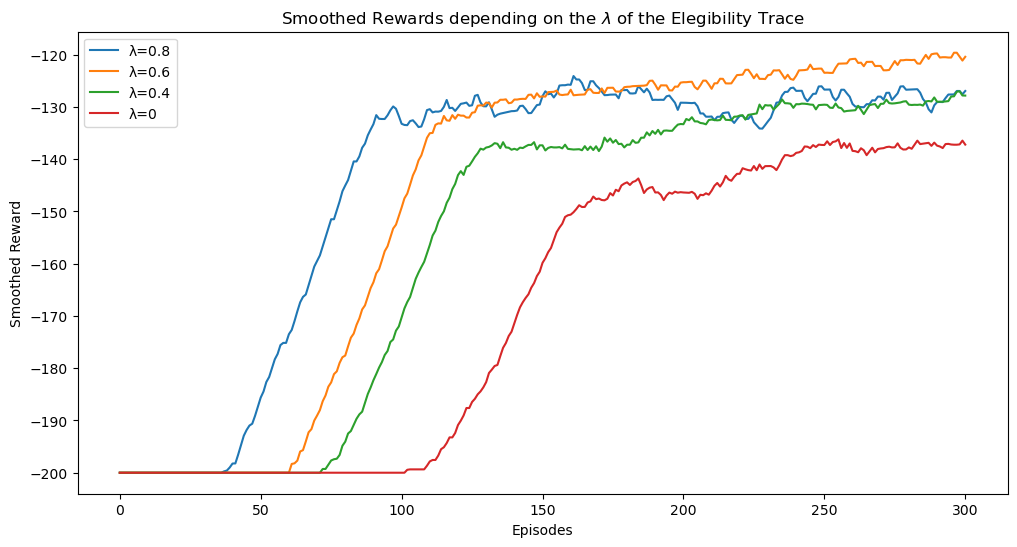

In [17]:


if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "λ": [0.8, 0.6, 0.4, 0],      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction factor": 0.7,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "nothing", 
        "defined_coeffs":  predefined_coeff_matrix_5,
    }

    # Run the hyperparameter search
    all_rewards, all_labels, test_avg_rewards, test_confidences = run_hyperparameter_search(hyperparameters, num_episodes=300, test_episodes=50)
   
    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=False)
    #plot_test_results(test_avg_rewards, test_confidences, [1, 0.8, 0.6, 0.4, 0])


Starting training for combination 1/10: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.9}


100%|██████████| 300/300 [00:04<00:00, 66.13it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 144.00it/s]


Policy achieves an average total reward of -130.4 +/- 3.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/10: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.8}


100%|██████████| 300/300 [00:04<00:00, 68.78it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 156.34it/s]


Policy achieves an average total reward of -126.8 +/- 8.7 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/10: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.7}


100%|██████████| 300/300 [00:04<00:00, 68.58it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 177.81it/s]


Policy achieves an average total reward of -123.4 +/- 4.7 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 4/10: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.6}


100%|██████████| 300/300 [00:04<00:00, 72.72it/s]


Training for combination 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 173.05it/s]


Policy achieves an average total reward of -116.0 +/- 2.6 with confidence 95%.
Your policy passed the test!
Testing for combination 4 completed!
Starting training for combination 5/10: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.5}


100%|██████████| 300/300 [00:04<00:00, 70.26it/s]


Training for combination 5 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 149.51it/s]


Policy achieves an average total reward of -123.7 +/- 4.8 with confidence 95%.
Your policy passed the test!
Testing for combination 5 completed!
Starting training for combination 6/10: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.4}


100%|██████████| 300/300 [00:04<00:00, 68.37it/s]


Training for combination 6 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 169.48it/s]


Policy achieves an average total reward of -119.9 +/- 3.5 with confidence 95%.
Your policy passed the test!
Testing for combination 6 completed!
Starting training for combination 7/10: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.3}


100%|██████████| 300/300 [00:04<00:00, 68.19it/s]


Training for combination 7 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 169.36it/s]


Policy achieves an average total reward of -126.1 +/- 4.0 with confidence 95%.
Your policy passed the test!
Testing for combination 7 completed!
Starting training for combination 8/10: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.2}


100%|██████████| 300/300 [00:04<00:00, 60.53it/s]


Training for combination 8 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 165.14it/s]


Policy achieves an average total reward of -128.3 +/- 5.9 with confidence 95%.
Your policy passed the test!
Testing for combination 8 completed!
Starting training for combination 9/10: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0.1}


100%|██████████| 300/300 [00:04<00:00, 61.85it/s]


Training for combination 9 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 143.68it/s]


Policy achieves an average total reward of -148.6 +/- 6.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 9 completed!
Starting training for combination 10/10: {'alpha': 0.001, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'λ': 0}


100%|██████████| 300/300 [00:05<00:00, 59.19it/s]


Training for combination 10 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 141.88it/s]


Policy achieves an average total reward of -140.0 +/- 5.7 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 10 completed!


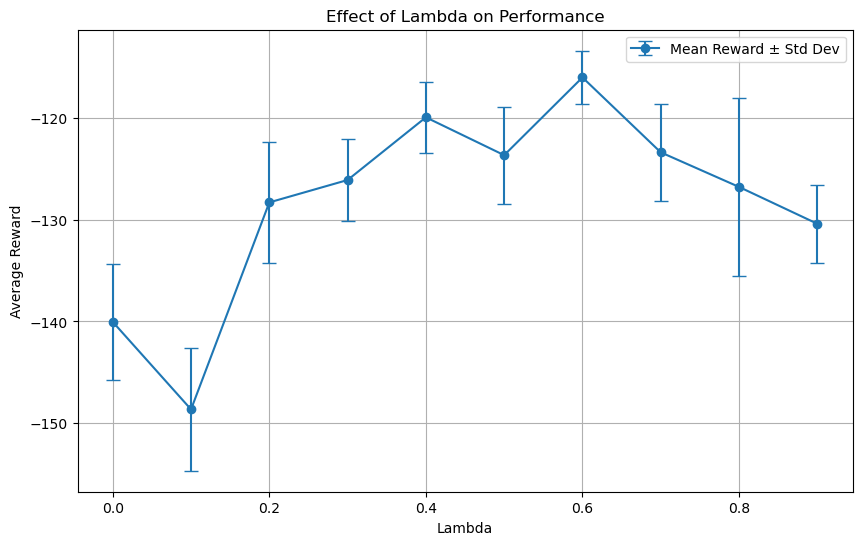

In [15]:
if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "λ": [0.9, 0.8, 0.7, 0.6, 0.5,0.4, 0.3, 0.2, 0.1,0],      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction factor": 0.7,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "nothing", 
        "defined_coeffs":  predefined_coeff_matrix_5,
    }

    # Run the hyperparameter search
    all_rewards, all_labels, test_avg_rewards, test_confidences = run_hyperparameter_search(hyperparameters, num_episodes=300, test_episodes=50)
   
    # Plot results
    #plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=False)
    plot_test_results(test_avg_rewards, test_confidences, [0.9, 0.8, 0.7, 0.6, 0.5,0.4, 0.3, 0.2, 0.1,0])


Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 123.47it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 321.36it/s]


Policy achieves an average total reward of -128.2 +/- 5.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 125.03it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 362.37it/s]


Policy achieves an average total reward of -119.1 +/- 4.5 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 122.76it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 370.81it/s]


Policy achieves an average total reward of -113.5 +/- 1.7 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 138.20it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 333.06it/s]


Policy achieves an average total reward of -133.1 +/- 6.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 138.54it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 361.54it/s]


Policy achieves an average total reward of -123.1 +/- 5.6 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 118.68it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 372.05it/s]


Policy achieves an average total reward of -115.9 +/- 6.5 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 142.91it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 318.46it/s]


Policy achieves an average total reward of -123.6 +/- 5.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 134.15it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 352.47it/s]


Policy achieves an average total reward of -116.3 +/- 6.2 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:04<00:00, 71.91it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 204.87it/s]


Policy achieves an average total reward of -190.5 +/- 2.1 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 122.76it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 267.53it/s]


Policy achieves an average total reward of -122.1 +/- 4.6 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 125.98it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 369.67it/s]


Policy achieves an average total reward of -120.1 +/- 4.2 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 135.05it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 399.56it/s]


Policy achieves an average total reward of -113.2 +/- 3.5 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 132.89it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 352.70it/s]


Policy achieves an average total reward of -122.7 +/- 4.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 143.25it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 338.17it/s]


Policy achieves an average total reward of -132.0 +/- 8.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:03<00:00, 97.60it/s] 


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 214.73it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 130.81it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 332.54it/s]


Policy achieves an average total reward of -122.6 +/- 4.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 129.77it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 271.35it/s]


Policy achieves an average total reward of -123.5 +/- 4.5 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 134.16it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 392.31it/s]


Policy achieves an average total reward of -110.2 +/- 3.9 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 137.44it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 334.09it/s]


Policy achieves an average total reward of -120.8 +/- 3.5 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 133.58it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 362.75it/s]


Policy achieves an average total reward of -117.4 +/- 3.7 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 134.08it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 374.20it/s]


Policy achieves an average total reward of -118.2 +/- 3.5 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 140.07it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 396.26it/s]


Policy achieves an average total reward of -113.5 +/- 1.6 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 141.41it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 391.61it/s]


Policy achieves an average total reward of -112.4 +/- 5.2 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 141.66it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 369.10it/s]


Policy achieves an average total reward of -118.4 +/- 5.2 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 142.64it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 353.03it/s]


Policy achieves an average total reward of -127.5 +/- 7.3 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 102.01it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 226.87it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 110.66it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 372.53it/s]


Policy achieves an average total reward of -119.9 +/- 0.7 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 142.99it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 349.17it/s]


Policy achieves an average total reward of -124.8 +/- 3.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 141.68it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 358.82it/s]


Policy achieves an average total reward of -120.2 +/- 4.5 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 138.35it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 397.78it/s]


Policy achieves an average total reward of -111.1 +/- 2.3 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 141.12it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 374.32it/s]


Policy achieves an average total reward of -119.3 +/- 3.6 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 130.66it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 375.69it/s]


Policy achieves an average total reward of -117.5 +/- 8.8 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 104.28it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 255.16it/s]


Policy achieves an average total reward of -176.6 +/- 4.3 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 142.96it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 358.00it/s]


Policy achieves an average total reward of -124.7 +/- 3.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 135.00it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 376.08it/s]


Policy achieves an average total reward of -119.6 +/- 5.3 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 134.33it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 378.36it/s]


Policy achieves an average total reward of -117.4 +/- 4.1 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 141.59it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 367.84it/s]


Policy achieves an average total reward of -118.5 +/- 2.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 103.11it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 248.45it/s]


Policy achieves an average total reward of -187.0 +/- 2.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 148.81it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 388.66it/s]


Policy achieves an average total reward of -117.0 +/- 3.4 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 140.80it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 311.05it/s]


Policy achieves an average total reward of -147.2 +/- 7.7 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:03<00:00, 97.27it/s] 


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 215.48it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 101.41it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 228.44it/s]


Policy achieves an average total reward of -199.1 +/- 0.3 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 142.56it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 368.65it/s]


Policy achieves an average total reward of -124.0 +/- 3.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 136.32it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 255.61it/s]


Policy achieves an average total reward of -122.8 +/- 6.7 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 104.19it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 310.50it/s]


Policy achieves an average total reward of -136.2 +/- 3.4 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 135.32it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 338.32it/s]


Policy achieves an average total reward of -122.0 +/- 3.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 122.70it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 316.09it/s]


Policy achieves an average total reward of -126.2 +/- 5.2 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:03<00:00, 88.21it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 216.40it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 125.92it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 331.59it/s]


Policy achieves an average total reward of -123.5 +/- 3.7 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 128.93it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 346.84it/s]


Policy achieves an average total reward of -120.7 +/- 4.2 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 124.10it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 358.88it/s]


Policy achieves an average total reward of -120.0 +/- 5.5 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 125.31it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 342.80it/s]


Policy achieves an average total reward of -118.1 +/- 3.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 119.36it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 320.57it/s]


Policy achieves an average total reward of -118.2 +/- 3.2 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:03<00:00, 90.99it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 212.51it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 128.66it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 371.36it/s]


Policy achieves an average total reward of -120.2 +/- 4.6 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 114.23it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 375.49it/s]


Policy achieves an average total reward of -112.3 +/- 3.4 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 129.36it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 282.58it/s]


Policy achieves an average total reward of -131.7 +/- 6.9 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 125.04it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 340.28it/s]


Policy achieves an average total reward of -119.6 +/- 4.2 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 124.14it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 360.78it/s]


Policy achieves an average total reward of -120.2 +/- 4.1 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 135.73it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 289.83it/s]


Policy achieves an average total reward of -119.0 +/- 5.7 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 126.26it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 312.79it/s]


Policy achieves an average total reward of -126.9 +/- 6.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:03<00:00, 78.42it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 193.01it/s]


Policy achieves an average total reward of -187.4 +/- 1.4 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 124.61it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 363.71it/s]


Policy achieves an average total reward of -118.9 +/- 3.8 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 128.05it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 67.43it/s]


Policy achieves an average total reward of -123.7 +/- 3.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:11<00:00, 26.01it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 64.10it/s]


Policy achieves an average total reward of -115.1 +/- 2.2 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:09<00:00, 32.67it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 229.62it/s]


Policy achieves an average total reward of -189.3 +/- 1.3 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 132.77it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 343.51it/s]


Policy achieves an average total reward of -123.3 +/- 5.0 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:03<00:00, 97.26it/s] 


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 207.52it/s]


Policy achieves an average total reward of -178.0 +/- 3.7 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 132.41it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 283.90it/s]


Policy achieves an average total reward of -156.3 +/- 6.9 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 140.54it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 348.88it/s]


Policy achieves an average total reward of -118.4 +/- 3.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 112.52it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 202.39it/s]


Policy achieves an average total reward of -127.2 +/- 4.3 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 121.12it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 378.47it/s]


Policy achieves an average total reward of -114.5 +/- 5.9 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:03<00:00, 81.88it/s] 


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 267.11it/s]


Policy achieves an average total reward of -118.0 +/- 3.3 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 105.81it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 301.31it/s]


Policy achieves an average total reward of -132.4 +/- 6.4 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:03<00:00, 89.35it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 189.03it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 127.33it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 302.53it/s]


Policy achieves an average total reward of -134.5 +/- 7.1 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:08<00:00, 35.70it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 63.42it/s]


Policy achieves an average total reward of -123.4 +/- 5.1 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:03<00:00, 77.03it/s] 


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 387.56it/s]


Policy achieves an average total reward of -115.5 +/- 1.7 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 128.73it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 323.23it/s]


Policy achieves an average total reward of -126.1 +/- 5.5 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:03<00:00, 93.22it/s] 


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 221.12it/s]


Policy achieves an average total reward of -183.6 +/- 2.9 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 126.84it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 364.18it/s]


Policy achieves an average total reward of -123.9 +/- 4.8 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 140.42it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 374.08it/s]


Policy achieves an average total reward of -118.7 +/- 4.0 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:03<00:00, 98.07it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 212.00it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:03<00:00, 92.21it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 212.83it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 130.30it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 315.71it/s]


Policy achieves an average total reward of -120.0 +/- 4.1 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 128.87it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 347.93it/s]


Policy achieves an average total reward of -116.8 +/- 4.2 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 132.73it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 324.23it/s]


Policy achieves an average total reward of -121.7 +/- 4.5 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 120.96it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 287.46it/s]


Policy achieves an average total reward of -124.0 +/- 4.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 130.14it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 356.88it/s]


Policy achieves an average total reward of -122.6 +/- 4.6 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 135.70it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 398.26it/s]


Policy achieves an average total reward of -109.0 +/- 3.7 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 137.00it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 346.30it/s]


Policy achieves an average total reward of -126.6 +/- 4.3 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 111.63it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 237.38it/s]


Policy achieves an average total reward of -187.5 +/- 2.3 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 141.89it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 392.77it/s]


Policy achieves an average total reward of -112.6 +/- 4.6 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 137.86it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 384.41it/s]


Policy achieves an average total reward of -115.3 +/- 2.2 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:03<00:00, 98.76it/s] 


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 216.84it/s]


Policy achieves an average total reward of -191.3 +/- 2.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:03<00:00, 97.82it/s] 


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 225.12it/s]


Policy achieves an average total reward of -191.4 +/- 1.4 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 137.43it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 315.98it/s]


Policy achieves an average total reward of -118.8 +/- 3.4 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 137.71it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 358.15it/s]


Policy achieves an average total reward of -111.9 +/- 5.3 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 134.60it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 377.58it/s]


Policy achieves an average total reward of -112.6 +/- 2.5 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 137.20it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 348.69it/s]


Policy achieves an average total reward of -120.6 +/- 2.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 101.35it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 251.11it/s]


Policy achieves an average total reward of -174.9 +/- 4.5 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:02<00:00, 118.06it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 299.75it/s]


Policy achieves an average total reward of -113.0 +/- 3.2 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 113.64it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 287.94it/s]


Policy achieves an average total reward of -123.9 +/- 5.1 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:03<00:00, 89.59it/s] 


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 275.77it/s]


Policy achieves an average total reward of -124.1 +/- 4.8 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:04<00:00, 65.96it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 176.36it/s]


Policy achieves an average total reward of -190.2 +/- 1.7 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:02<00:00, 100.22it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 311.33it/s]


Policy achieves an average total reward of -116.8 +/- 3.3 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:02<00:00, 103.34it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 342.95it/s]


Policy achieves an average total reward of -106.3 +/- 2.6 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:08<00:00, 36.38it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 40.85it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 26.24it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 70.25it/s]


Policy achieves an average total reward of -118.5 +/- 3.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:11<00:00, 26.22it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 66.81it/s]


Policy achieves an average total reward of -124.5 +/- 6.8 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:11<00:00, 26.10it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 72.17it/s]


Policy achieves an average total reward of -108.4 +/- 3.0 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 26.38it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 69.60it/s]


Policy achieves an average total reward of -114.7 +/- 1.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:15<00:00, 19.08it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 45.93it/s]


Policy achieves an average total reward of -179.4 +/- 3.4 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:13<00:00, 22.92it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 71.41it/s]


Policy achieves an average total reward of -109.8 +/- 3.6 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 27.26it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 71.94it/s]


Policy achieves an average total reward of -120.7 +/- 2.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:15<00:00, 19.77it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 44.45it/s]


Policy achieves an average total reward of -180.2 +/- 3.2 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:15<00:00, 18.94it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 40.46it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 26.00it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 62.31it/s]


Policy achieves an average total reward of -122.5 +/- 4.7 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:11<00:00, 25.08it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 66.78it/s]


Policy achieves an average total reward of -124.0 +/- 5.3 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:11<00:00, 25.76it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 68.05it/s]


Policy achieves an average total reward of -114.8 +/- 8.2 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 25.50it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 63.59it/s]


Policy achieves an average total reward of -124.3 +/- 3.4 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:12<00:00, 24.23it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 67.72it/s]


Policy achieves an average total reward of -111.3 +/- 4.6 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:12<00:00, 24.87it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 65.60it/s]


Policy achieves an average total reward of -120.4 +/- 6.5 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 25.92it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 64.48it/s]


Policy achieves an average total reward of -118.3 +/- 3.6 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:12<00:00, 23.50it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 57.52it/s]


Policy achieves an average total reward of -140.1 +/- 7.7 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:16<00:00, 18.20it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 40.42it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 25.92it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 61.28it/s]


Policy achieves an average total reward of -125.7 +/- 3.9 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:13<00:00, 22.33it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 63.32it/s]


Policy achieves an average total reward of -118.6 +/- 0.5 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:16<00:00, 18.52it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 40.05it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 27.06it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 65.63it/s]


Policy achieves an average total reward of -121.9 +/- 5.3 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:11<00:00, 25.91it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 63.88it/s]


Policy achieves an average total reward of -119.9 +/- 4.5 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:15<00:00, 19.36it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 42.30it/s]


Policy achieves an average total reward of -188.0 +/- 2.1 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 26.42it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 58.49it/s]


Policy achieves an average total reward of -134.6 +/- 9.1 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:15<00:00, 19.08it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 39.29it/s]


Policy achieves an average total reward of -190.5 +/- 1.8 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:11<00:00, 26.32it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 64.34it/s]


Policy achieves an average total reward of -121.3 +/- 6.5 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 26.51it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 67.05it/s]


Policy achieves an average total reward of -121.3 +/- 3.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:13<00:00, 22.66it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 65.69it/s]


Policy achieves an average total reward of -112.9 +/- 3.1 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:12<00:00, 24.91it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 66.70it/s]


Policy achieves an average total reward of -113.3 +/- 5.2 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 25.31it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 58.39it/s]


Policy achieves an average total reward of -122.3 +/- 4.7 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:13<00:00, 22.59it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 70.59it/s]


Policy achieves an average total reward of -111.7 +/- 3.6 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:16<00:00, 18.22it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 38.74it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 26.30it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 65.33it/s]


Policy achieves an average total reward of -121.6 +/- 4.5 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:11<00:00, 26.21it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 66.92it/s]


Policy achieves an average total reward of -121.9 +/- 4.7 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:16<00:00, 18.27it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 38.73it/s]


Policy achieves an average total reward of -198.7 +/- 2.5 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 26.60it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 65.26it/s]


Policy achieves an average total reward of -118.9 +/- 4.1 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:11<00:00, 26.11it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 67.45it/s]


Policy achieves an average total reward of -117.4 +/- 5.2 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:11<00:00, 25.51it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 60.15it/s]


Policy achieves an average total reward of -120.0 +/- 4.1 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!
Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'zeros'}


100%|██████████| 300/300 [00:11<00:00, 25.85it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 61.63it/s]


Policy achieves an average total reward of -123.9 +/- 4.5 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random uniform'}


100%|██████████| 300/300 [00:15<00:00, 18.76it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 36.83it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'expl_strategy': 'e-greedy', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'initialization': 'random gaussian'}


100%|██████████| 300/300 [00:15<00:00, 19.12it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:01<00:00, 43.59it/s]


Policy achieves an average total reward of -188.5 +/- 1.9 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!


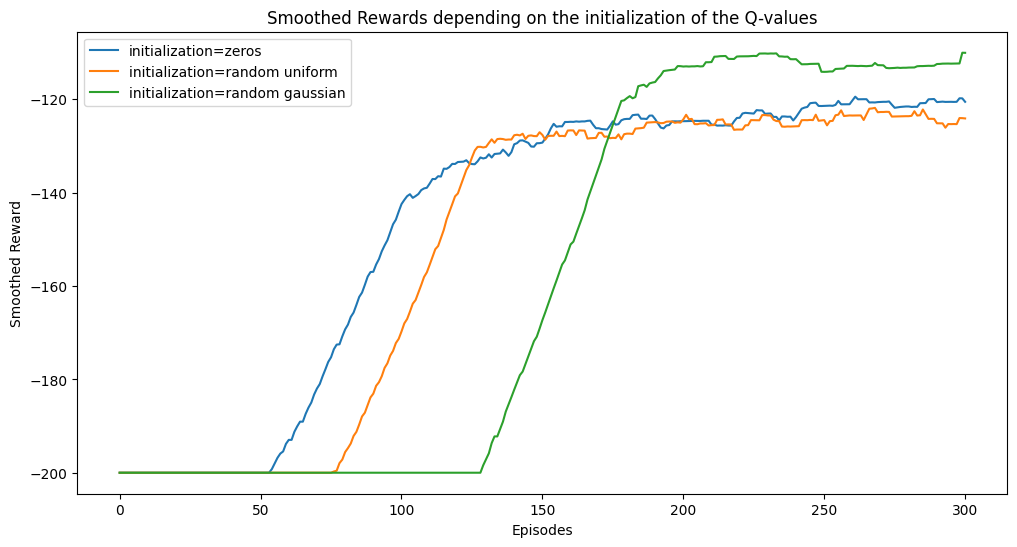

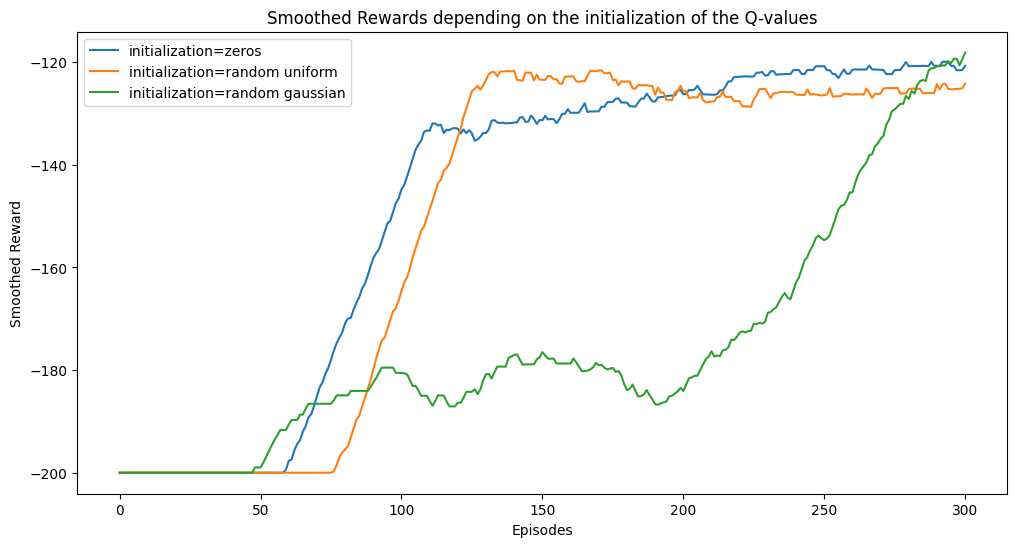

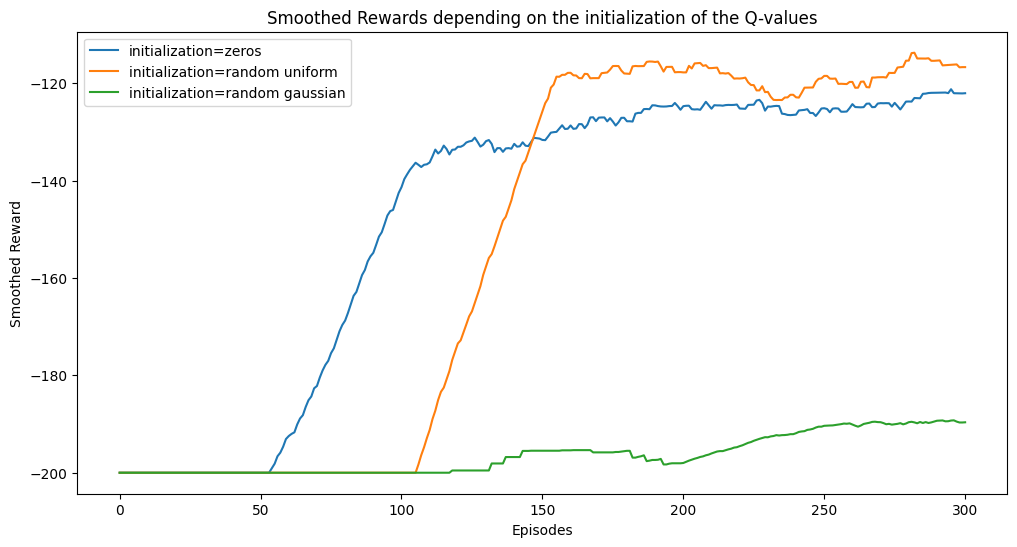

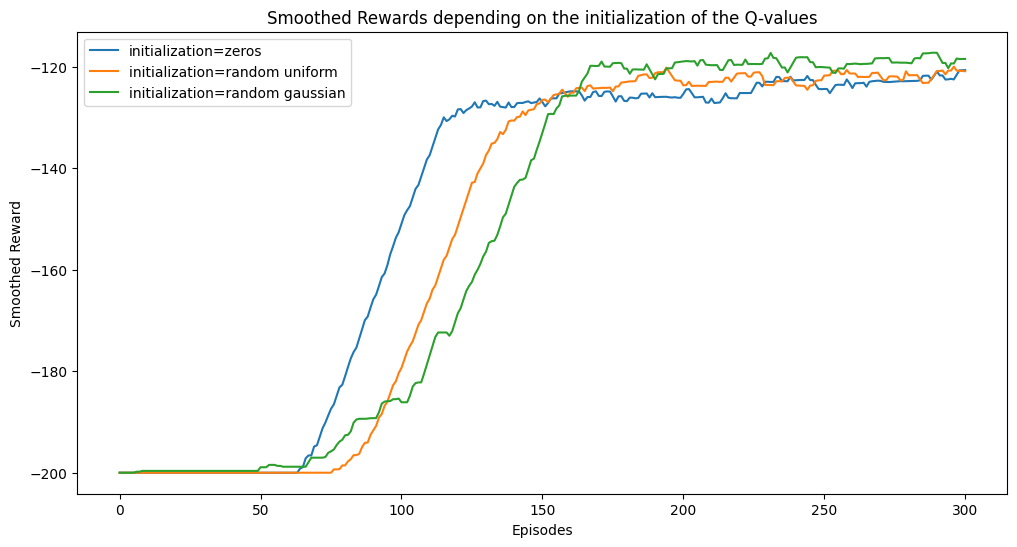

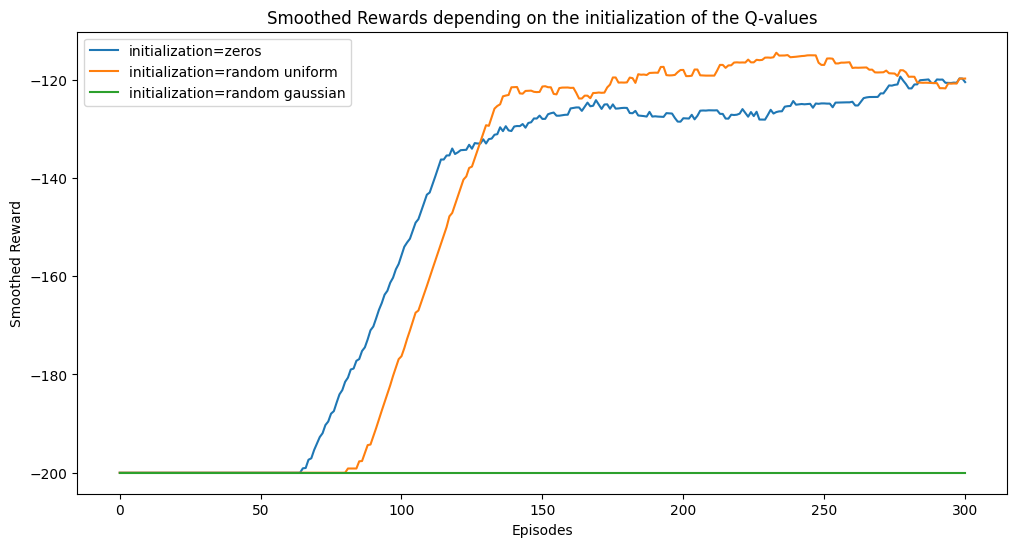

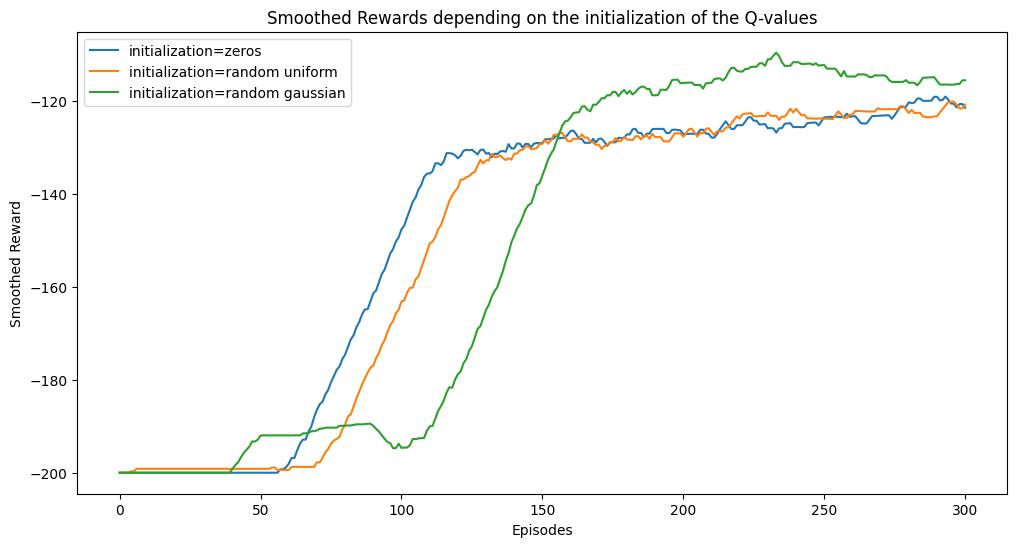

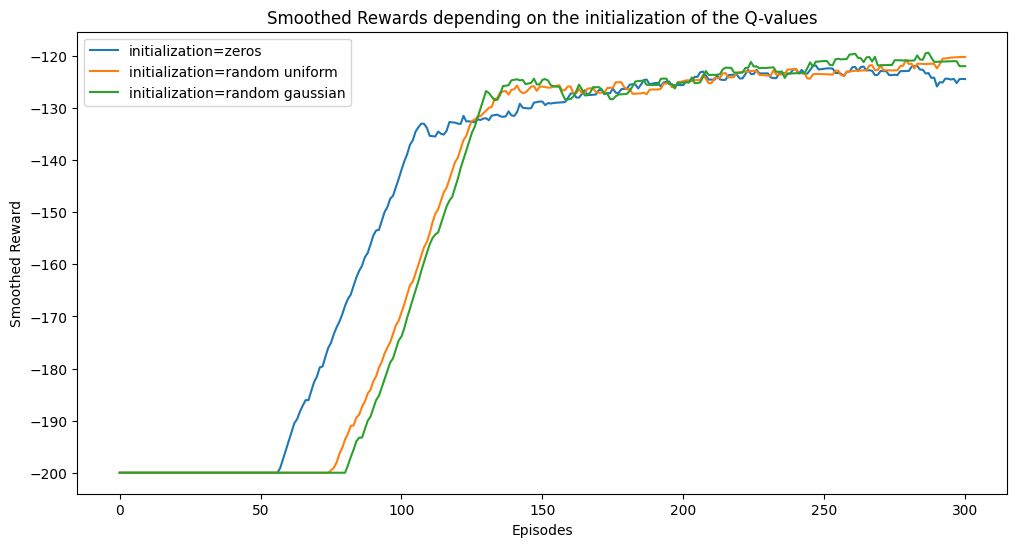

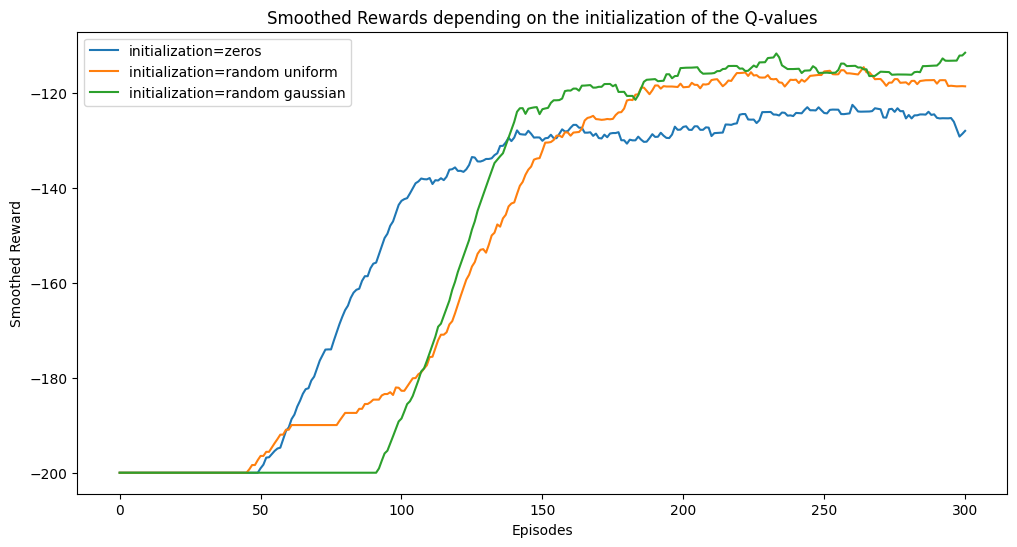

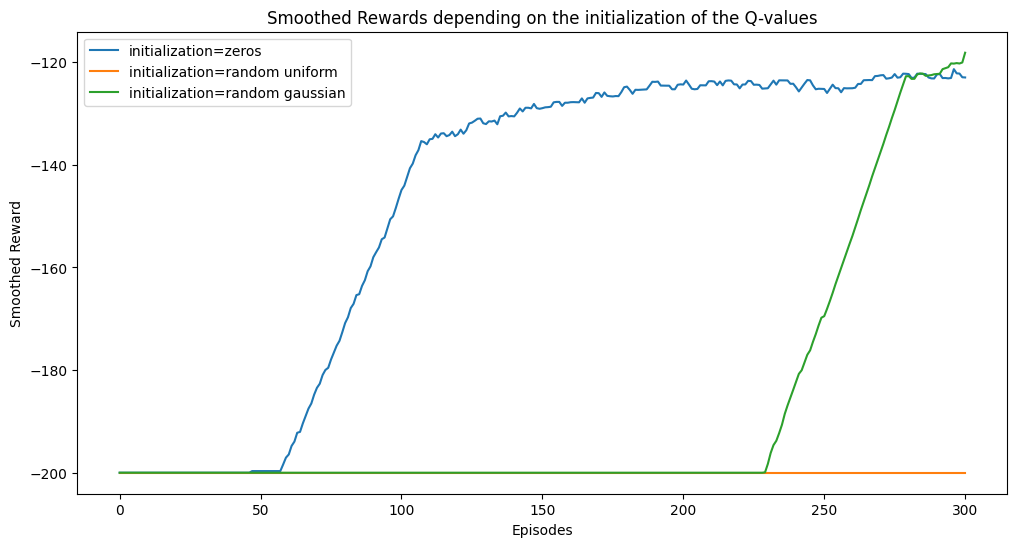

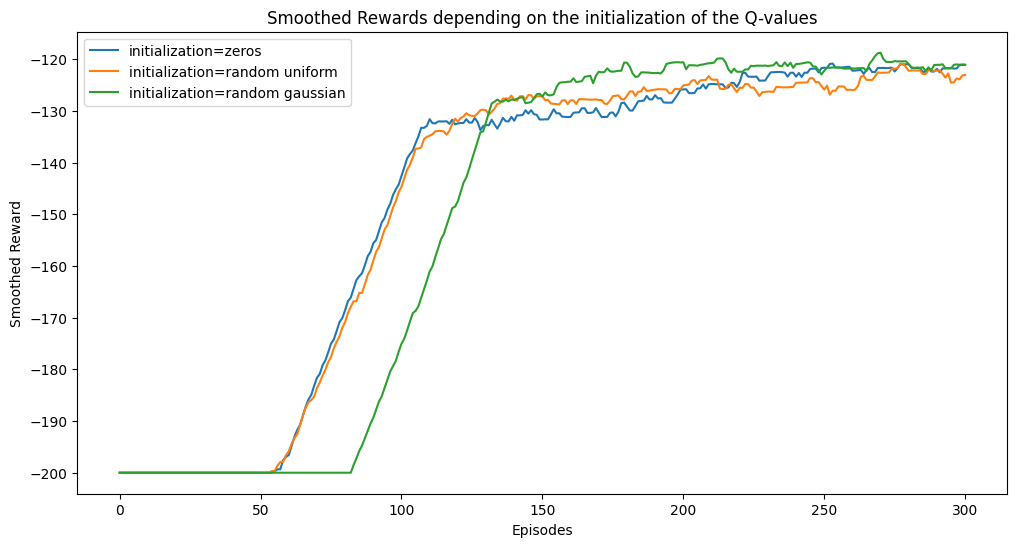

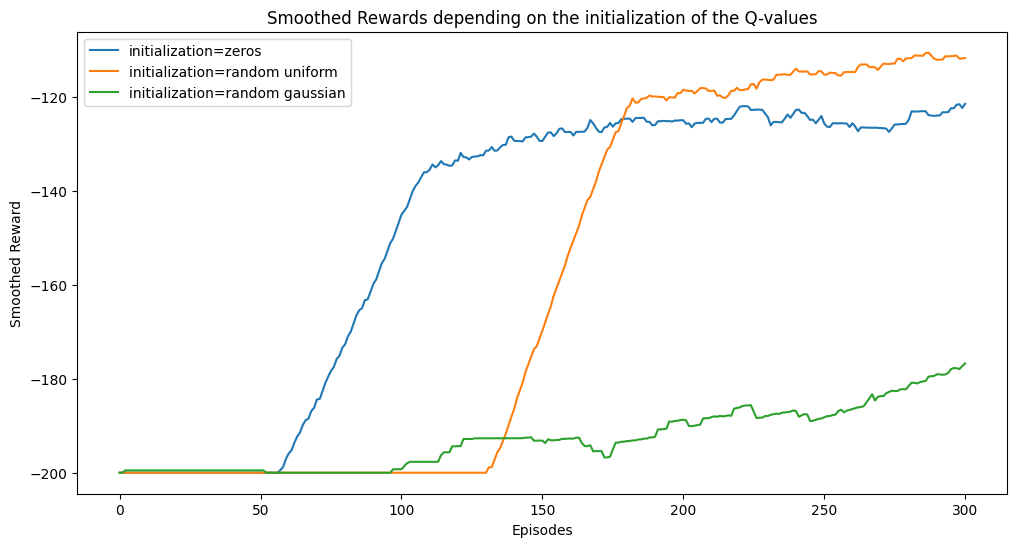

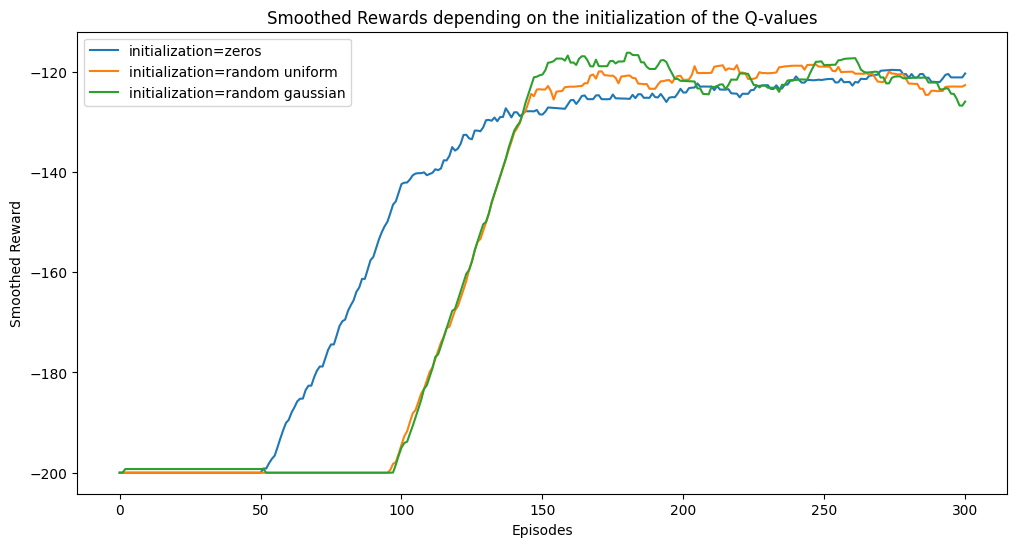

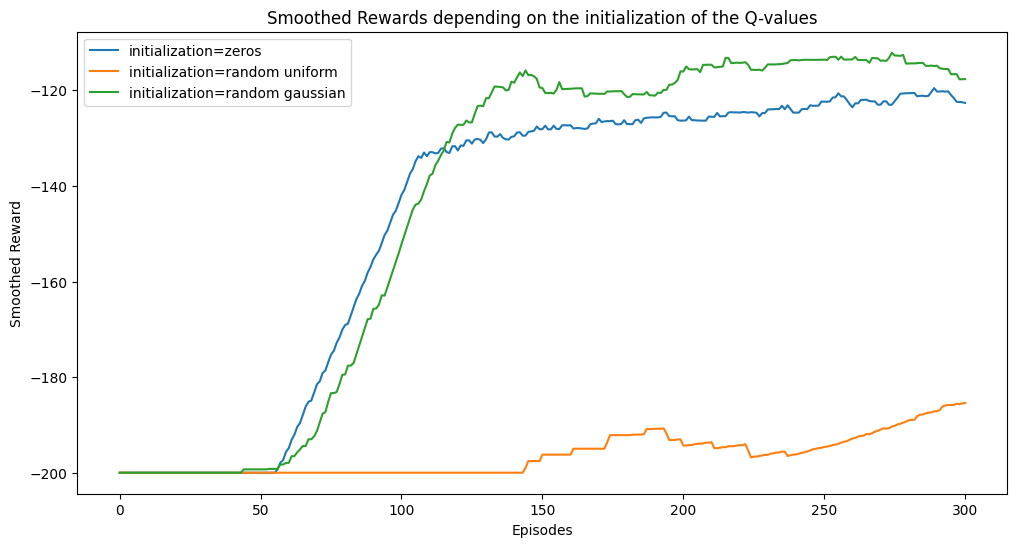

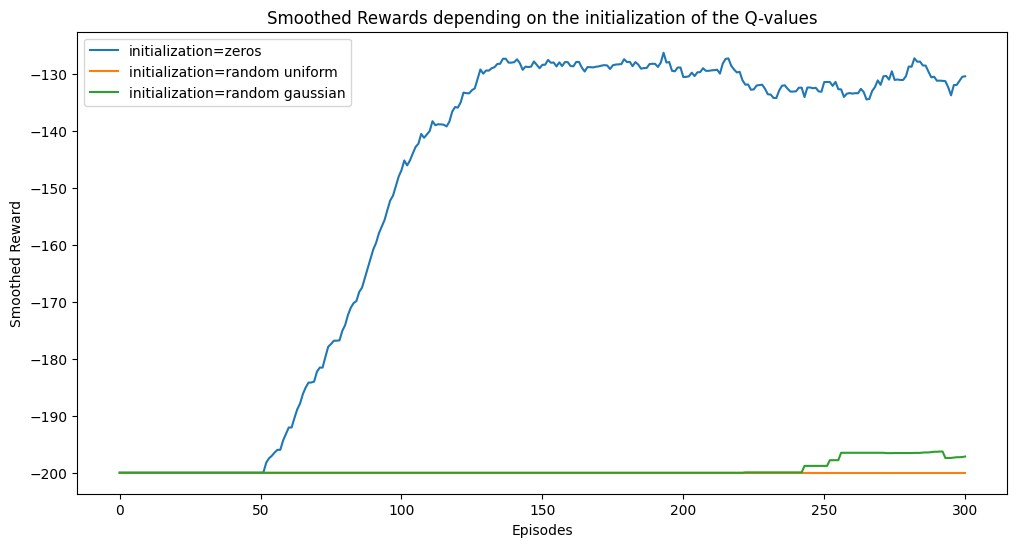

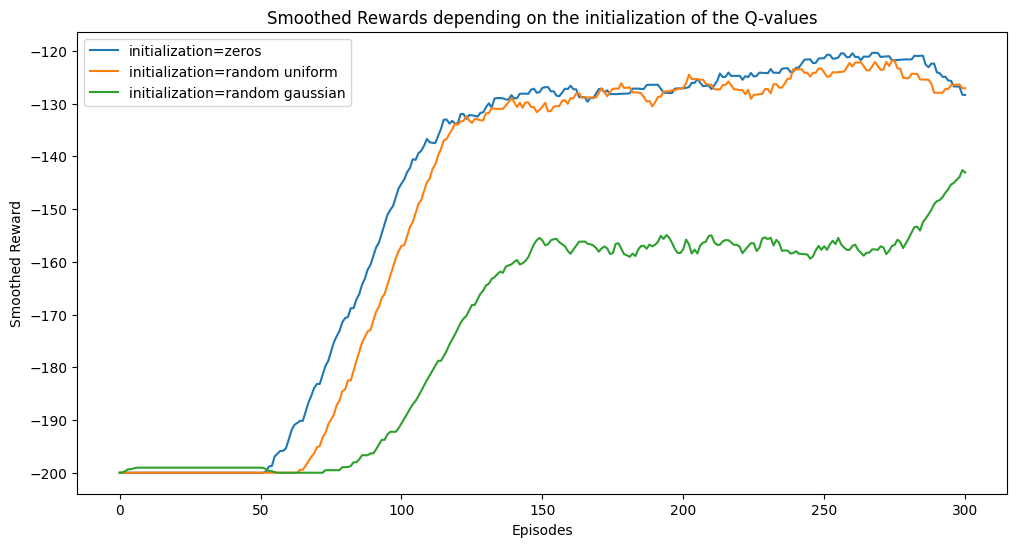

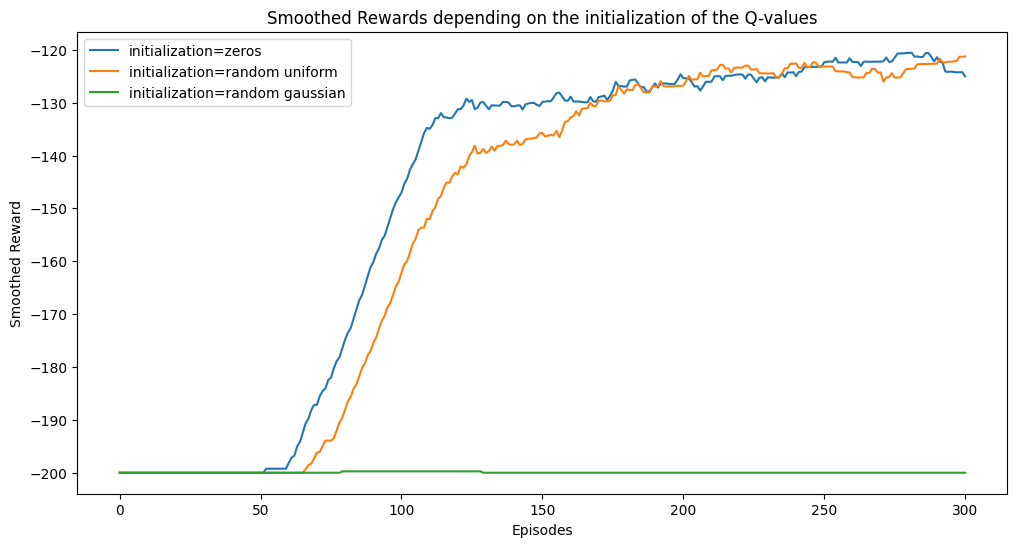

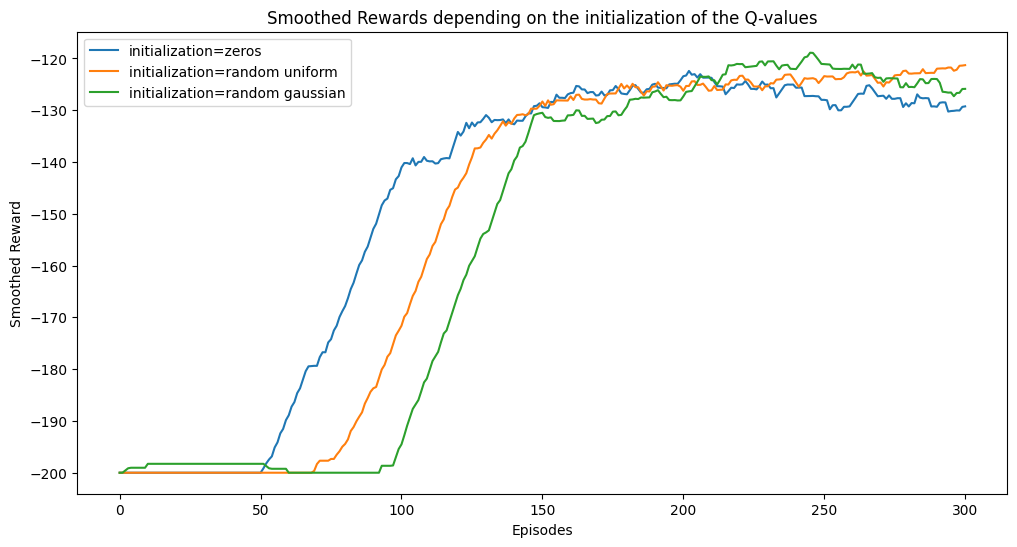

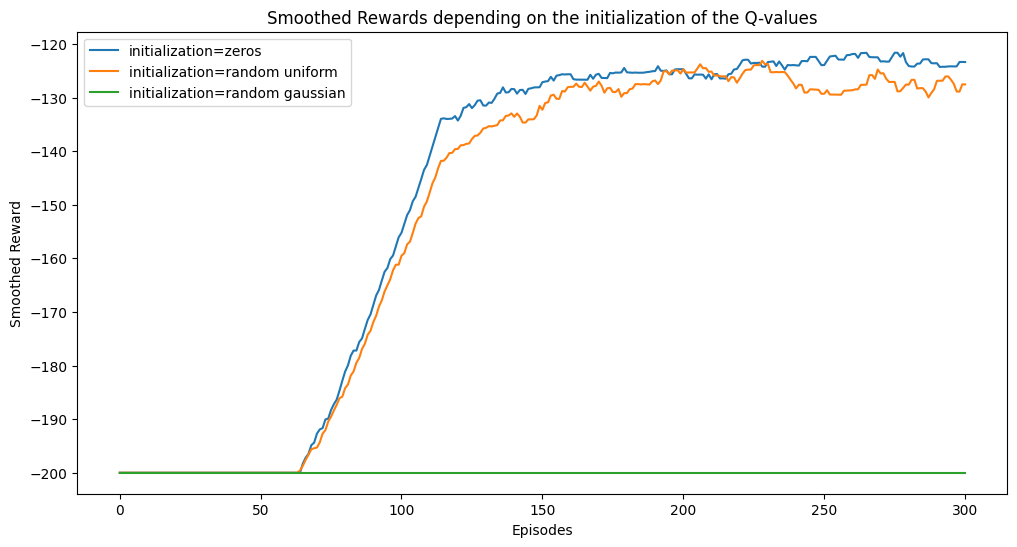

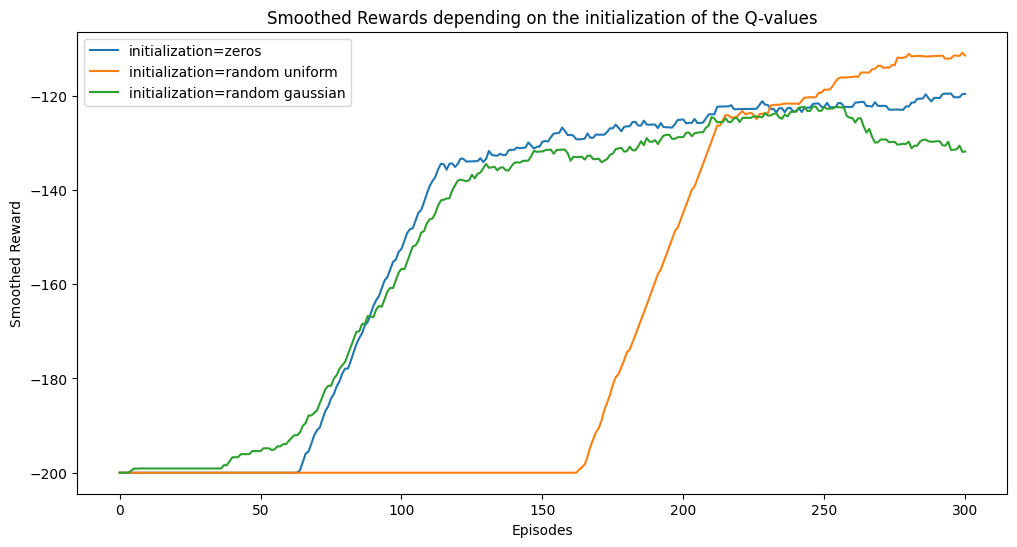

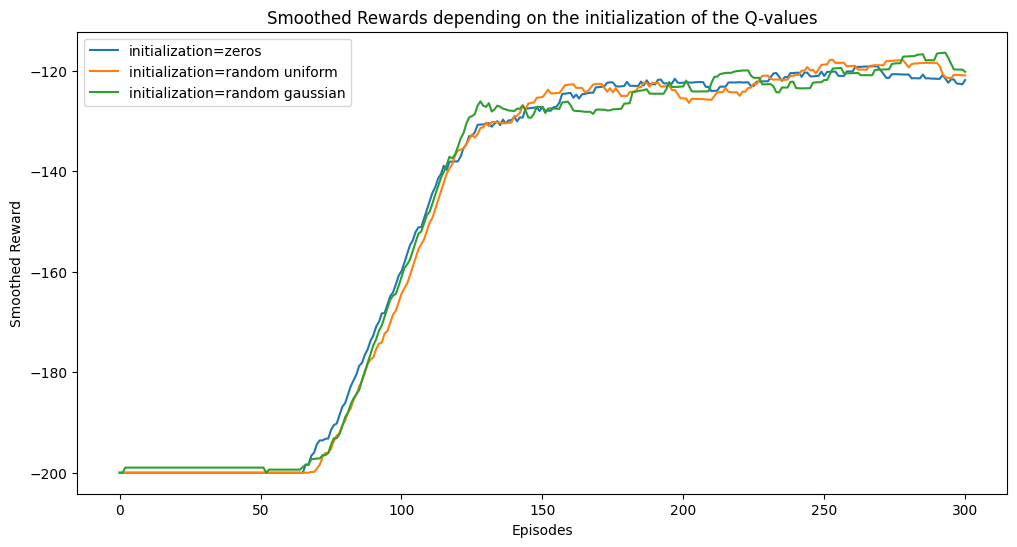

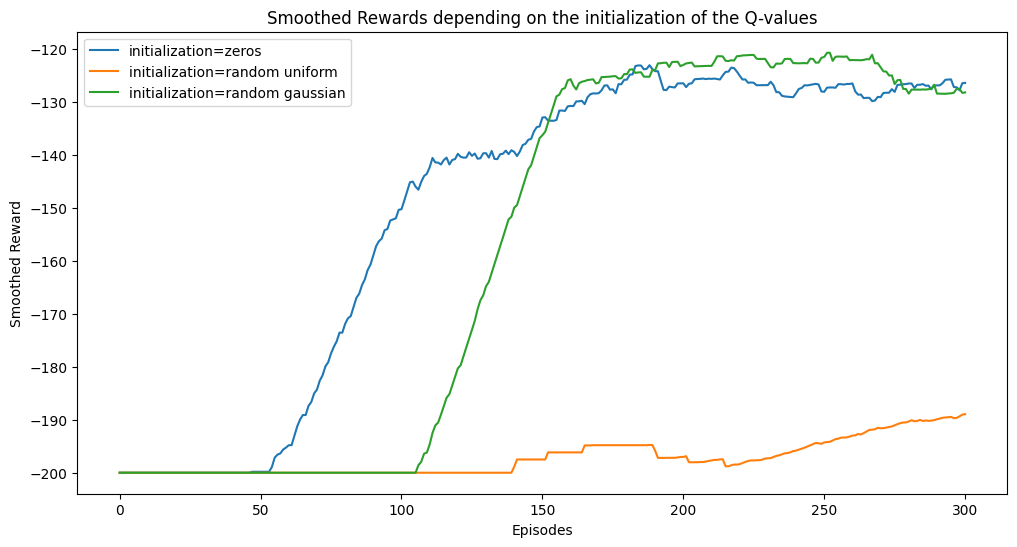

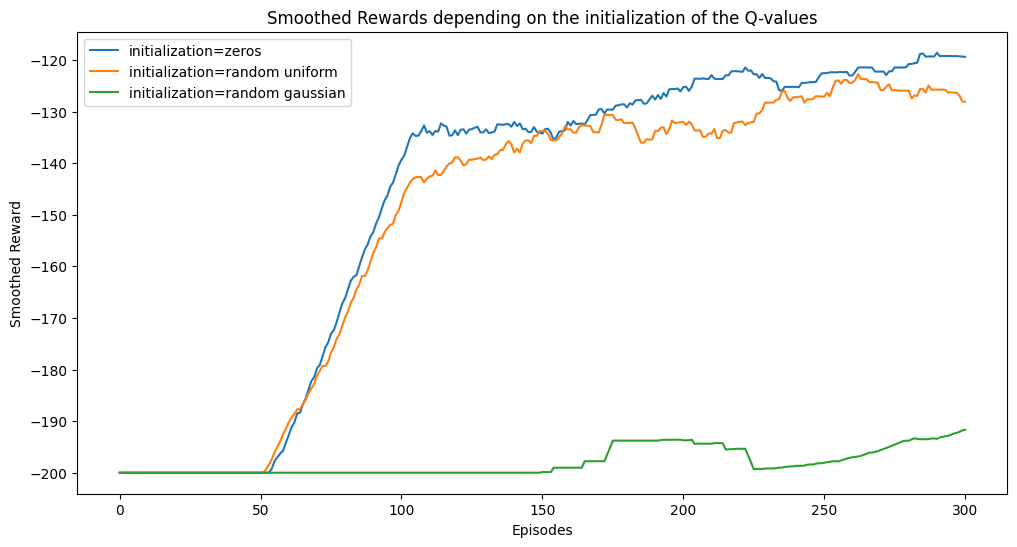

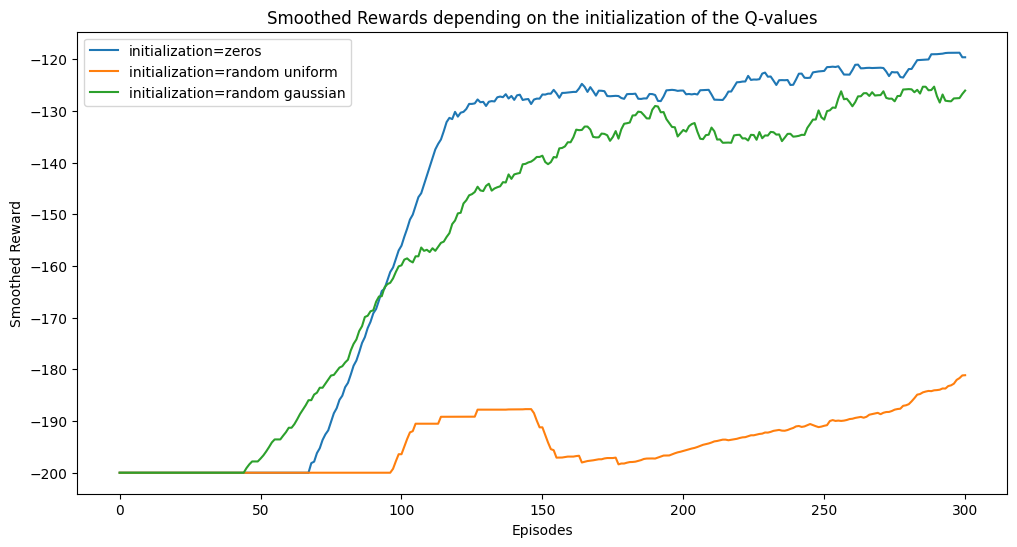

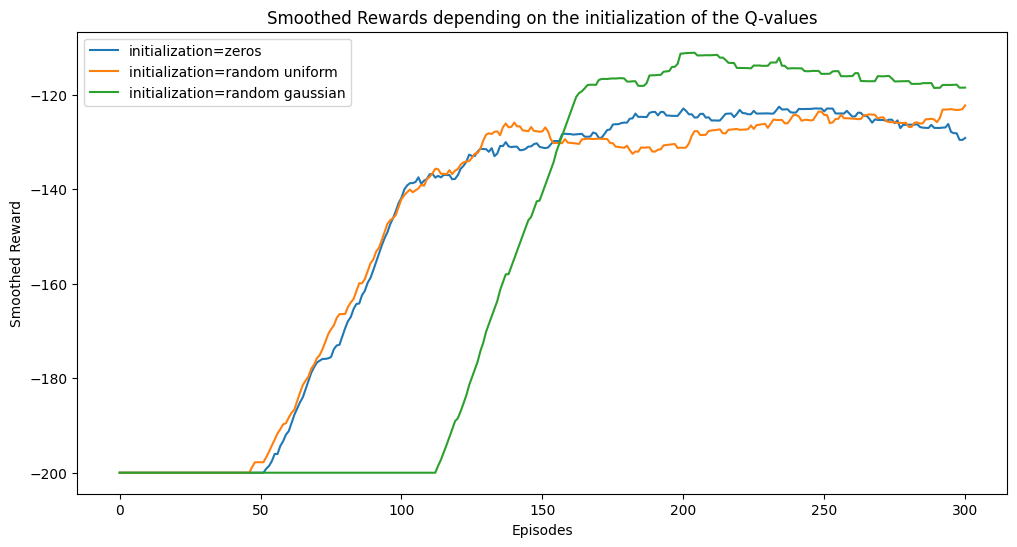

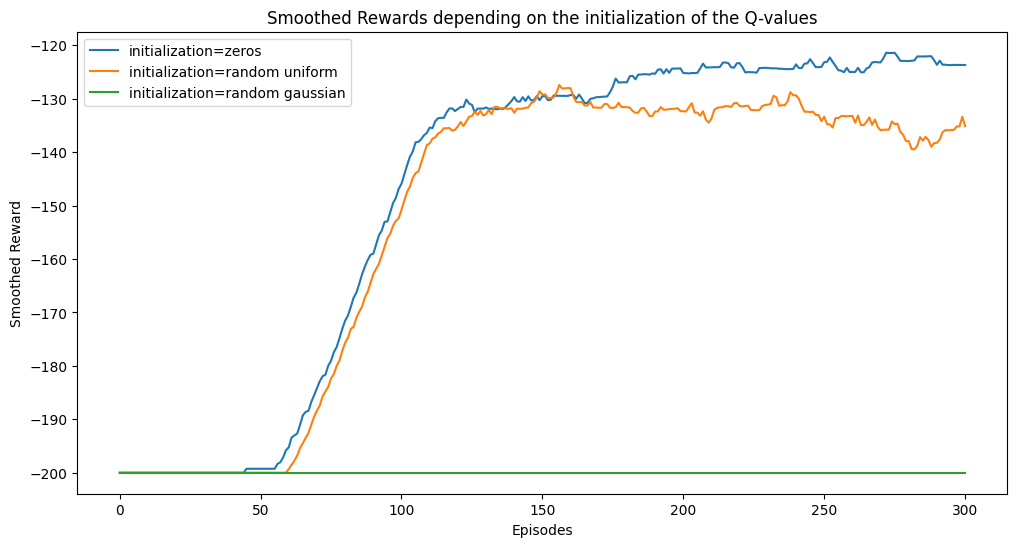

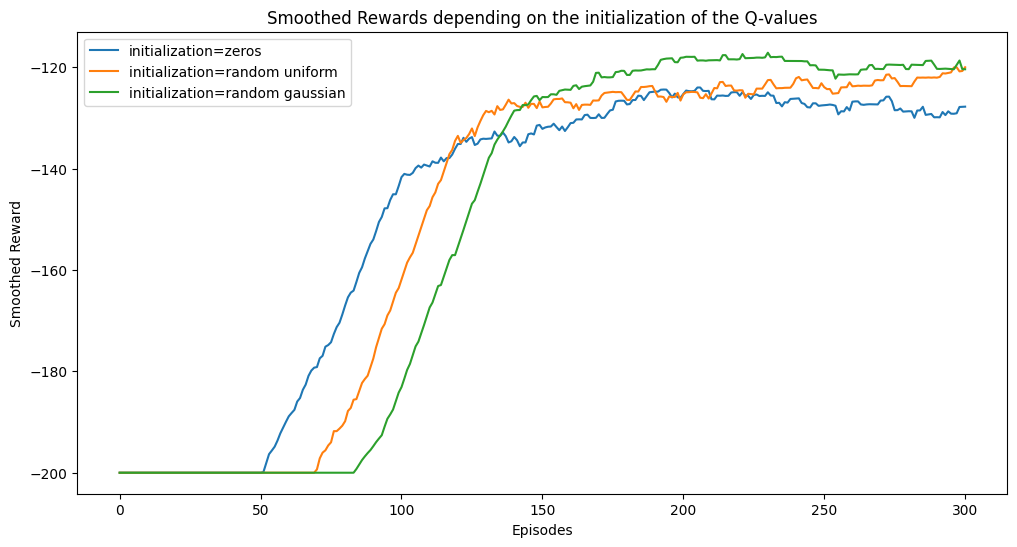

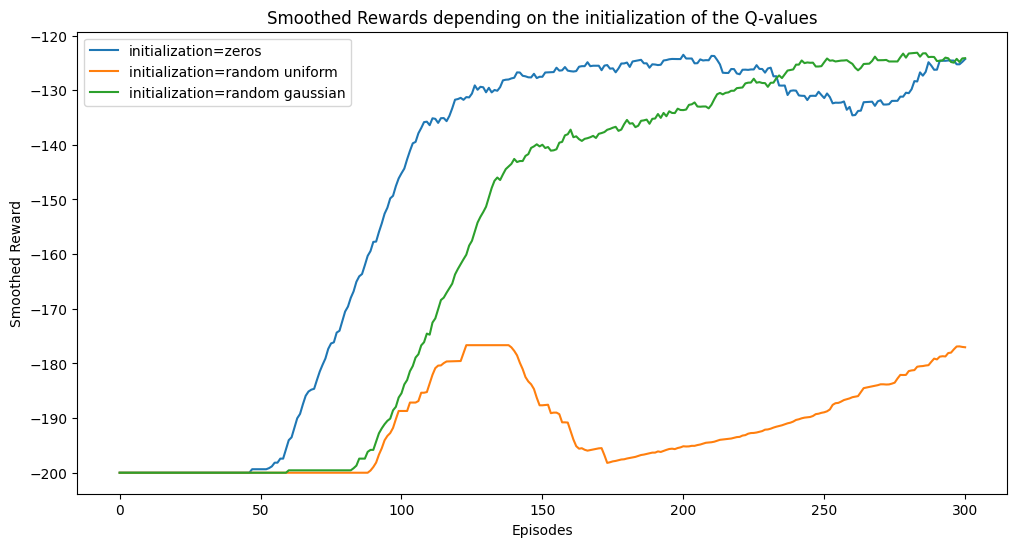

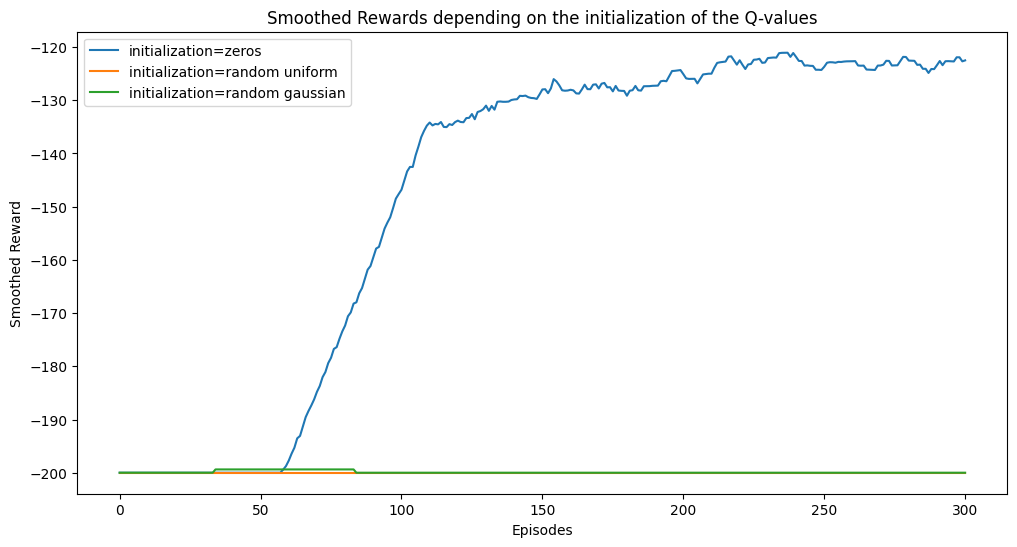

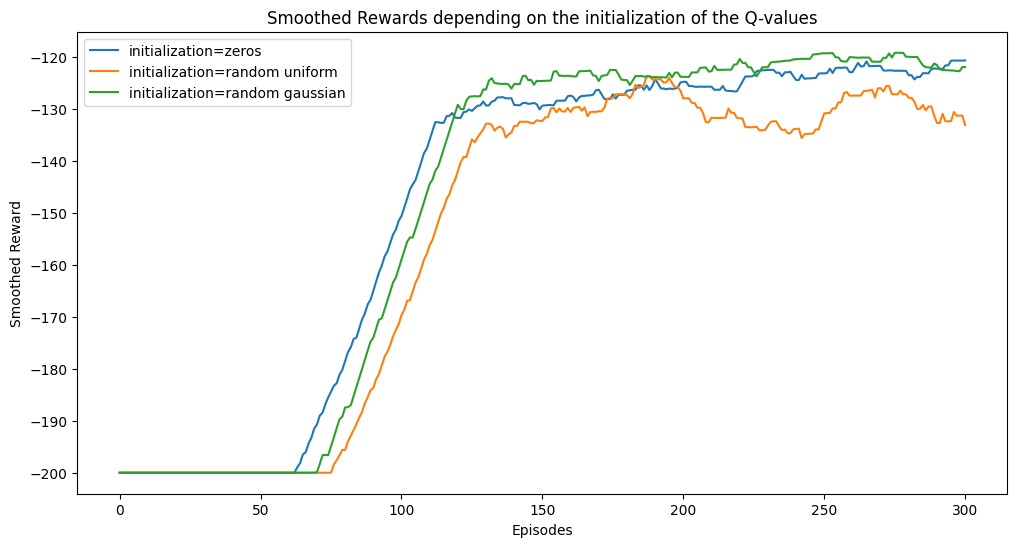

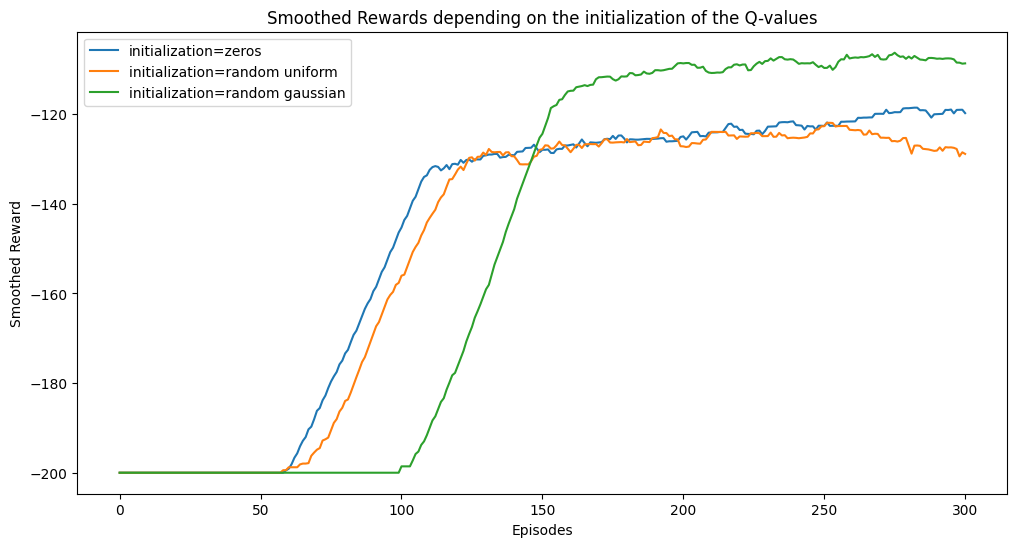

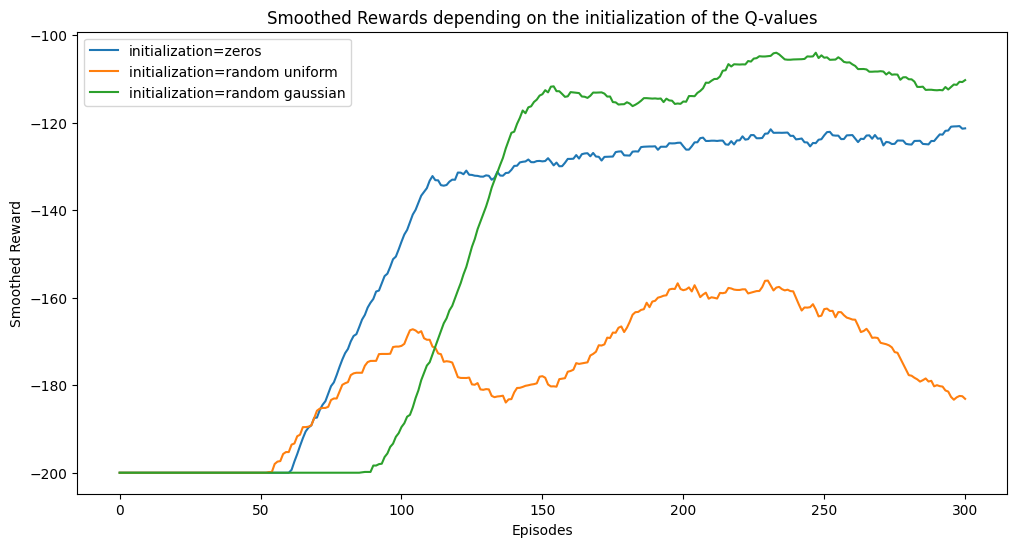

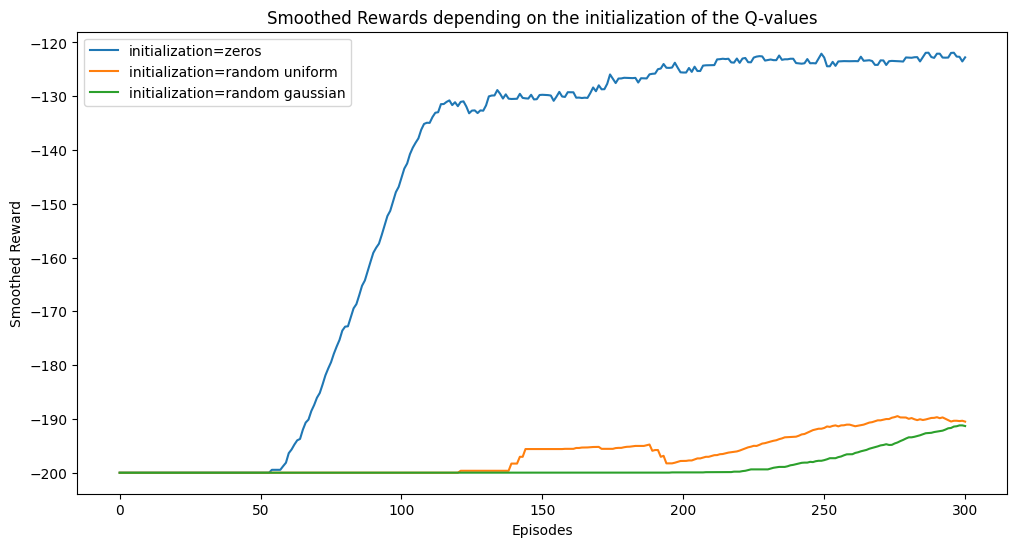

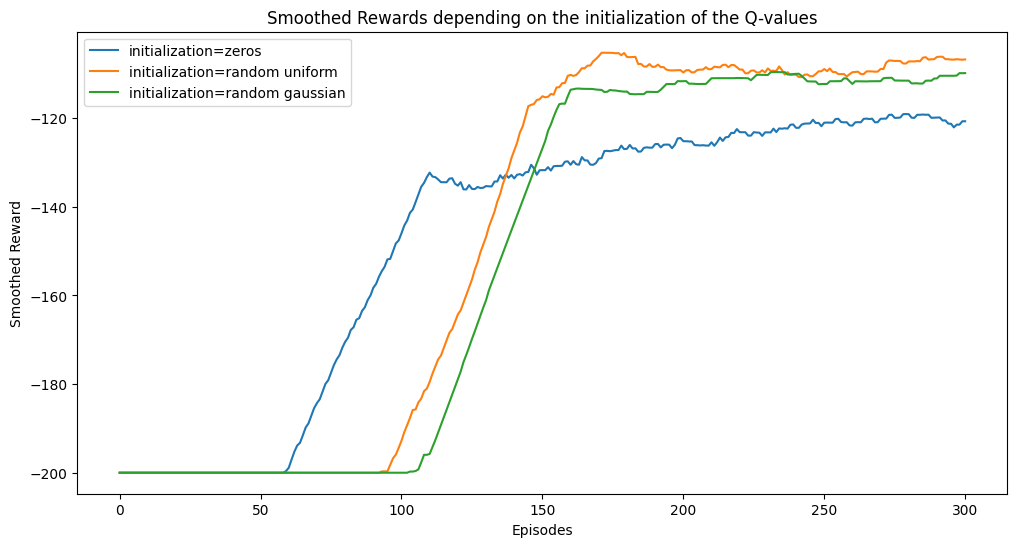

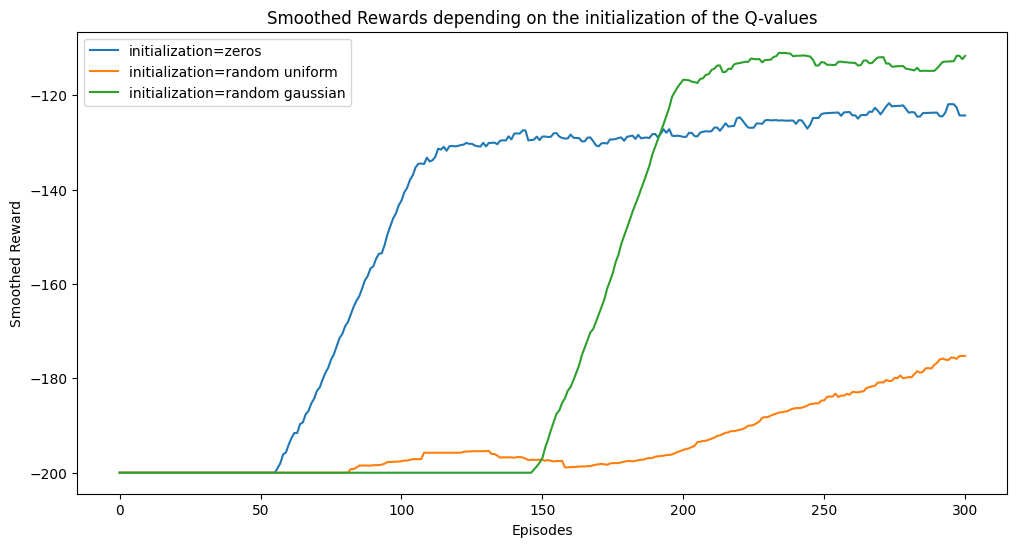

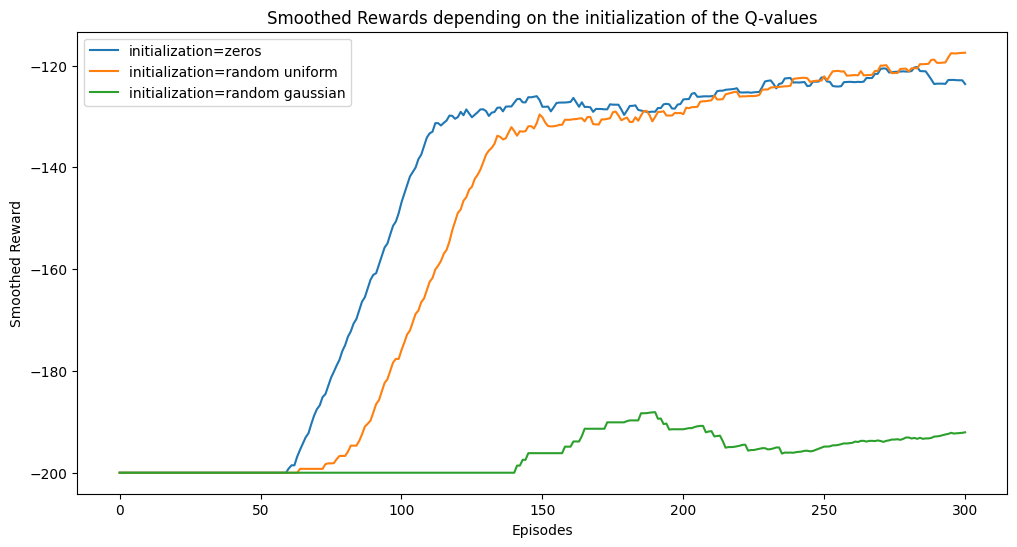

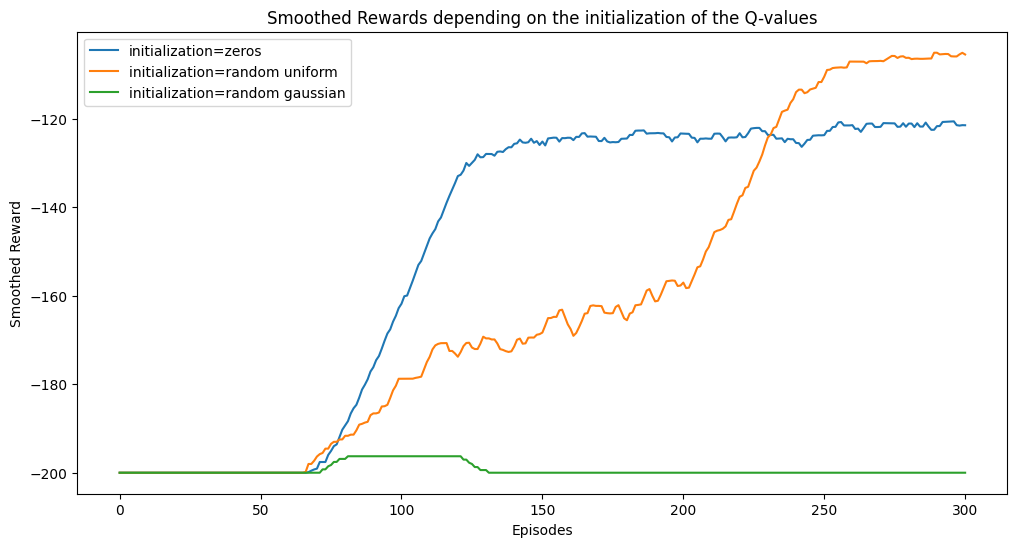

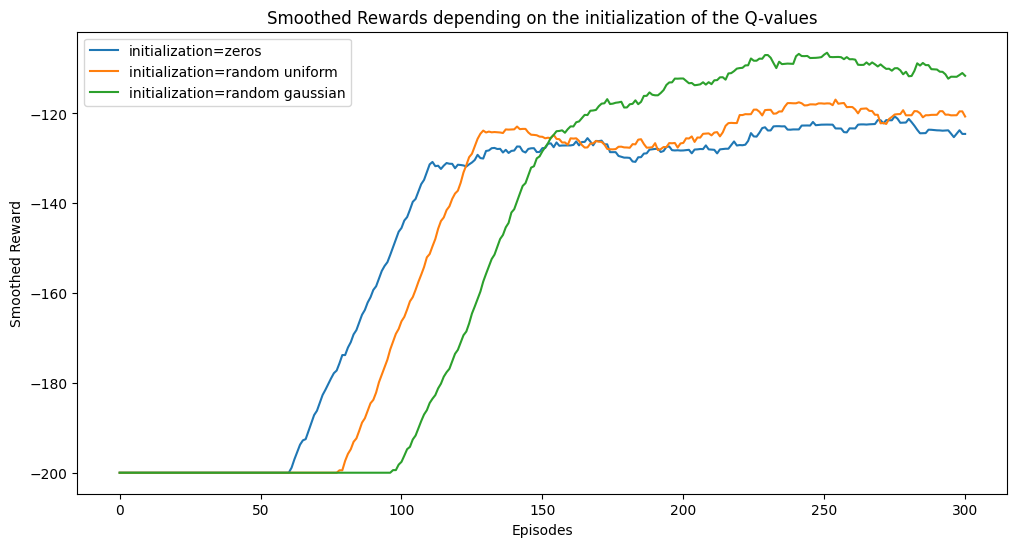

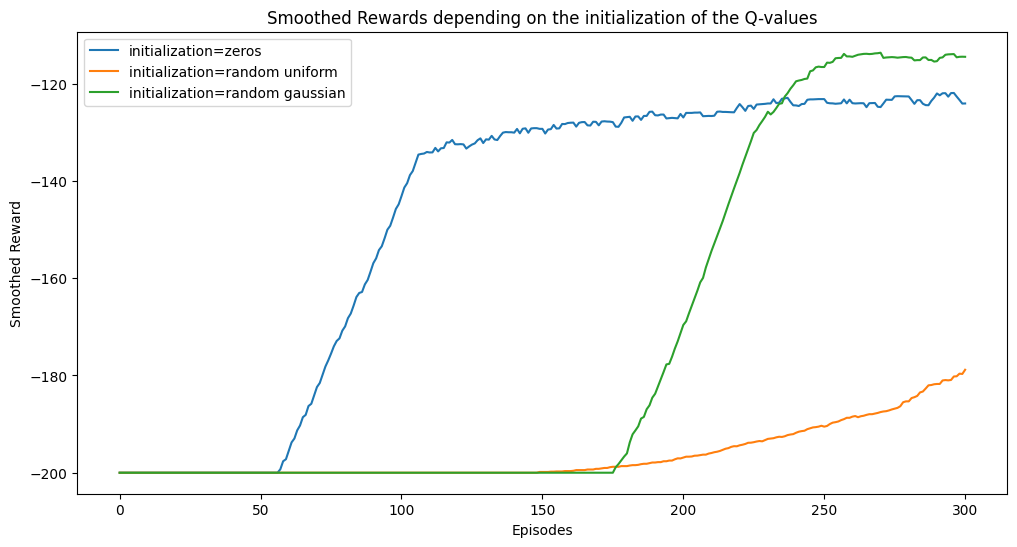

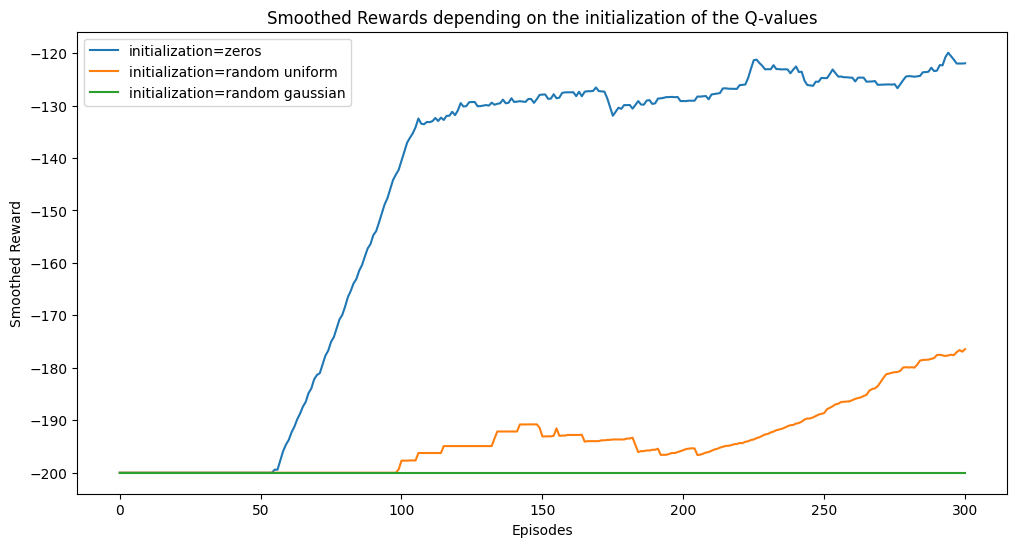

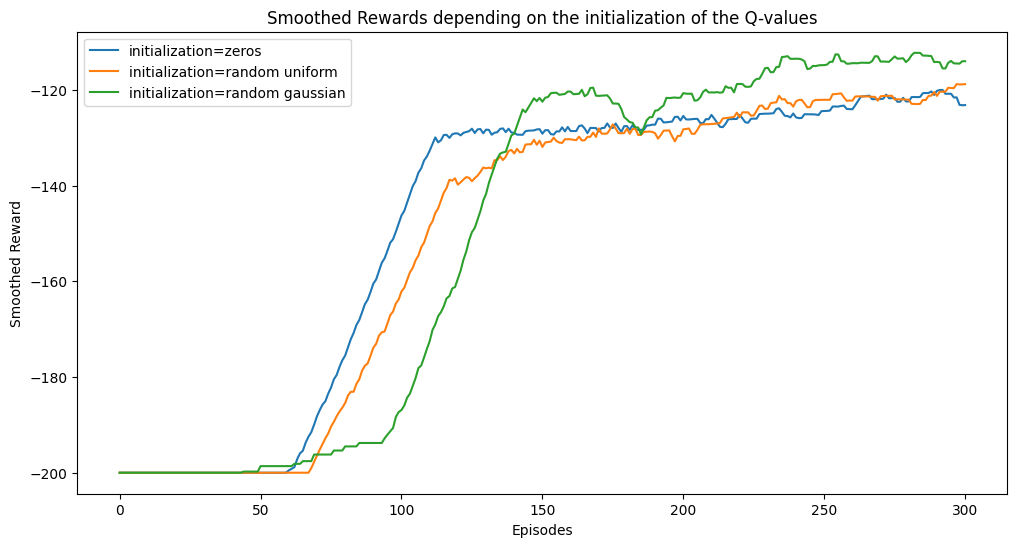

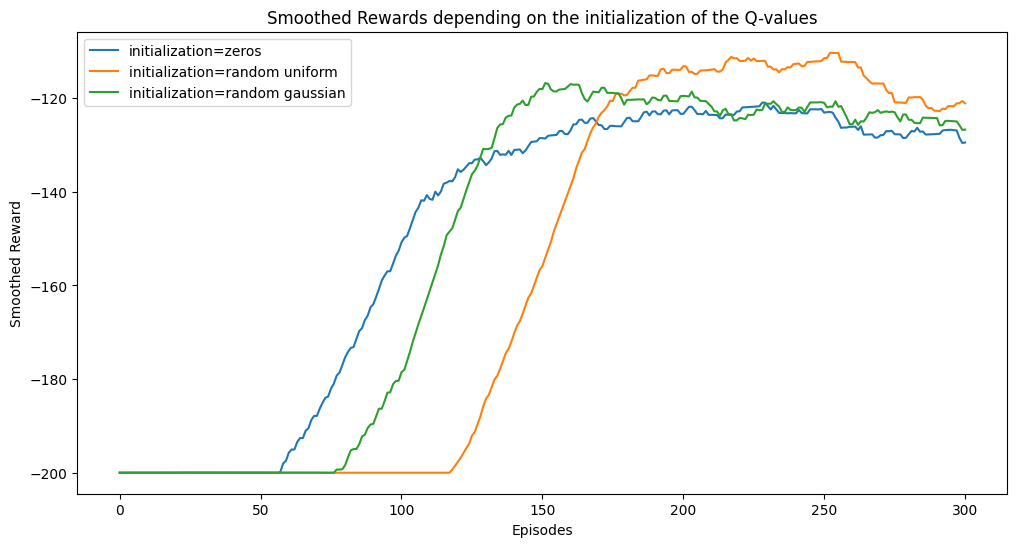

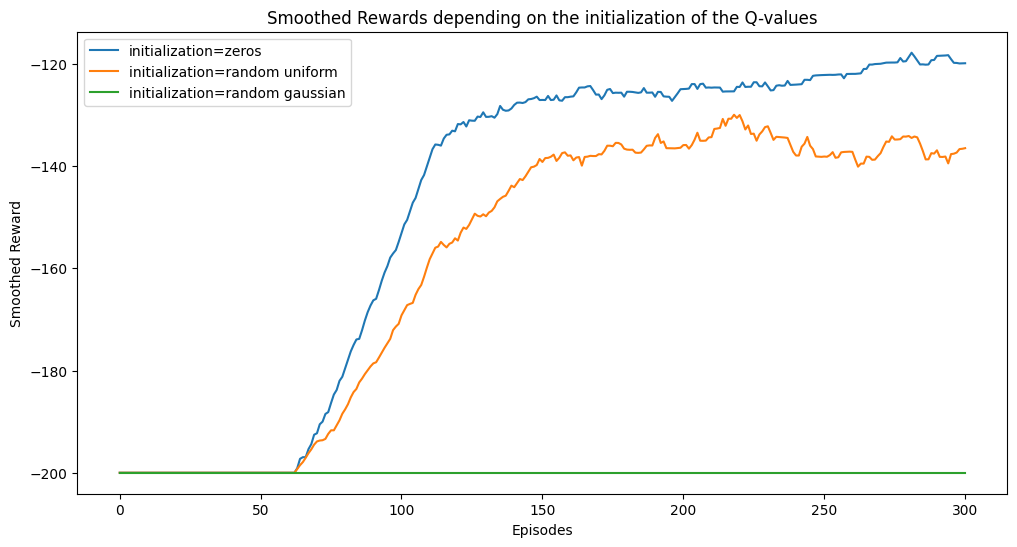

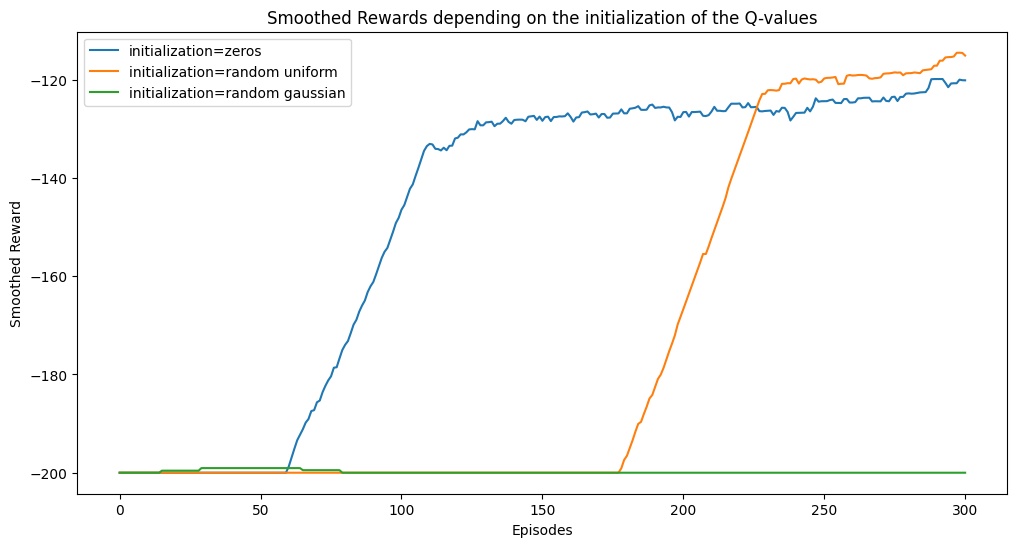

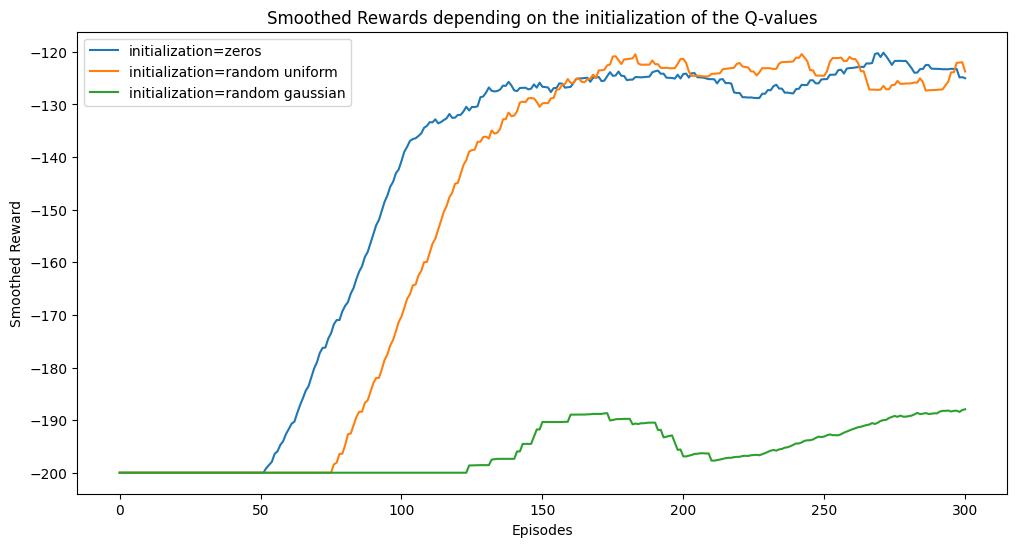

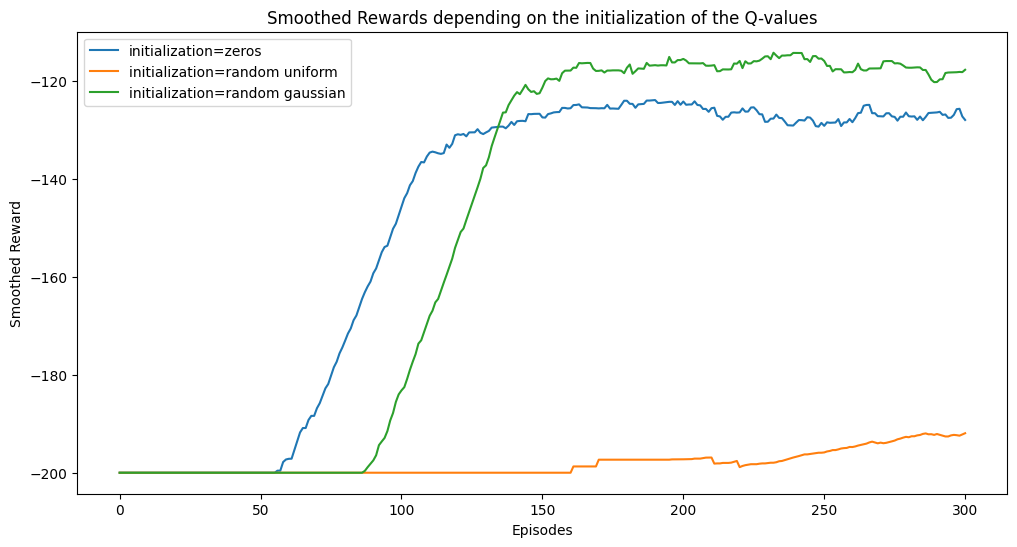

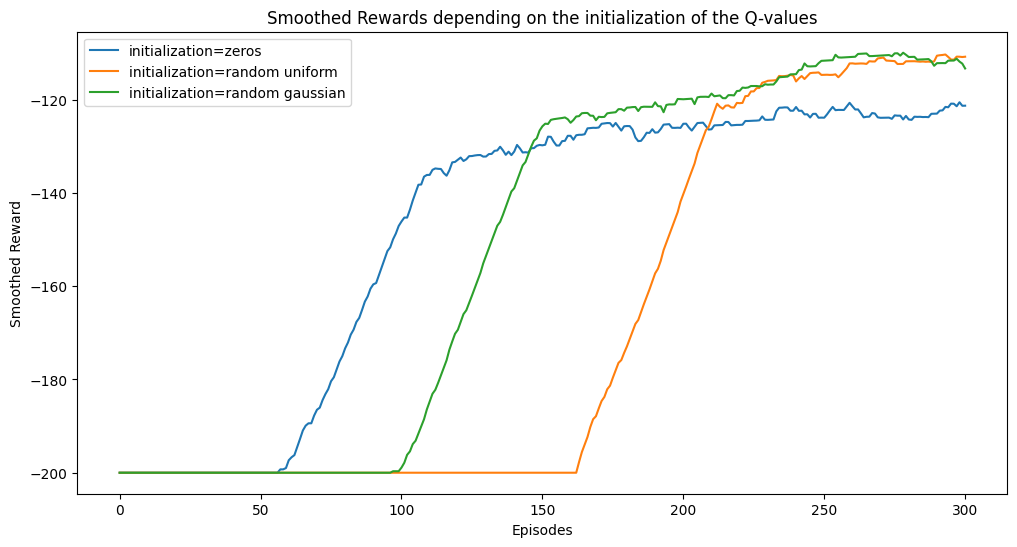

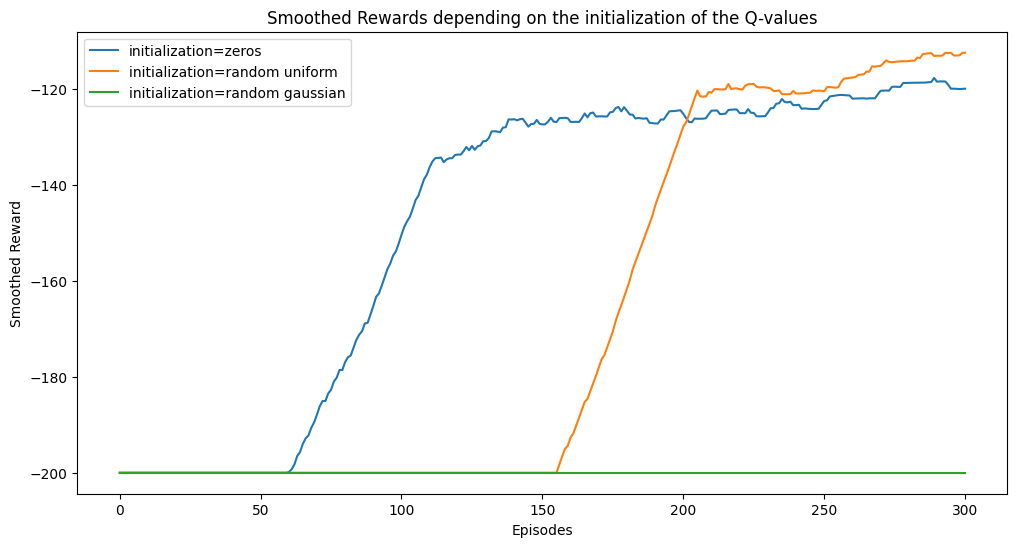

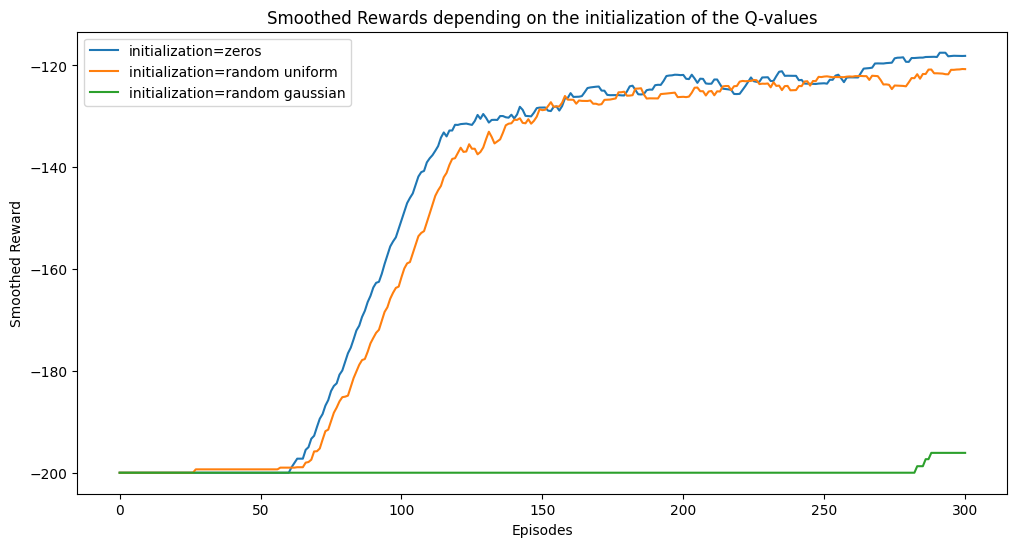

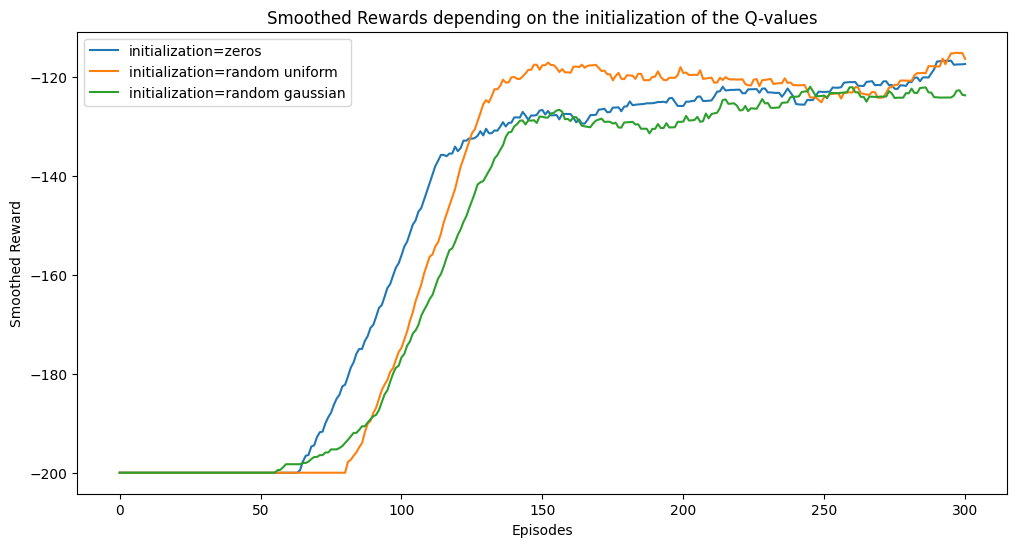

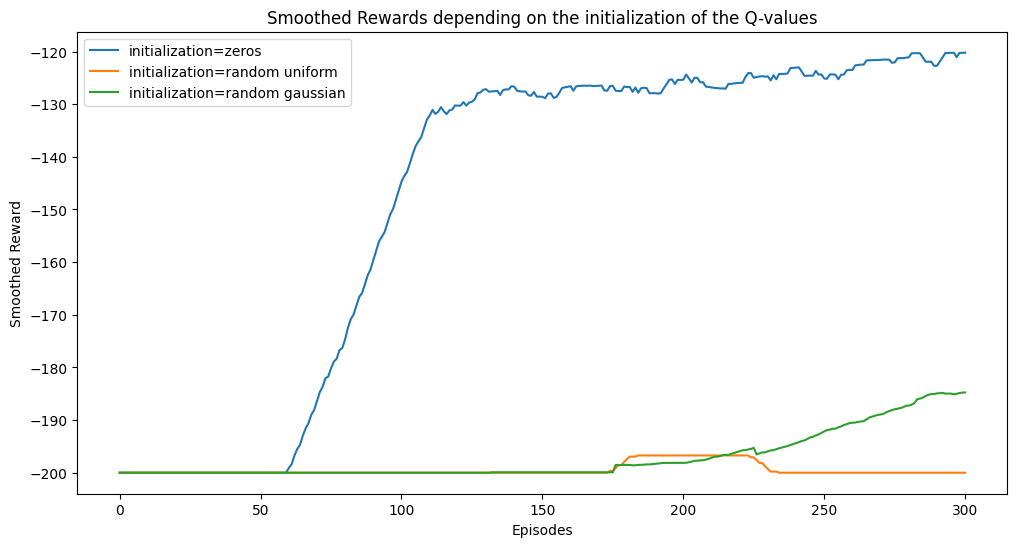

In [ ]:


if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "λ":  0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction factor": 0.7,  # LR reduction factor (fixed)
        "initialization": ["zeros",  "random uniform", "random gaussian"], # Weight initialization
        "expl_strategy": "e-greedy",
        "type_coeffs": "nothing", 
        "defined_coeffs":  predefined_coeff_matrix_5,
    }


    rewards = []
    # Run the hyperparameter search three times
    for i in range(10):
        all_rewards, all_labels, test_avg_rewards, test_confidences = run_hyperparameter_search(hyperparameters, num_episodes=300, test_episodes=50)
        rewards.append(all_rewards)

    rewards_zeros = []
    rewards_random_uniform = []
    rewards_random_gaussian = []

    for i in range(len(rewards)):
        plot_all_smoothed_rewards(rewards[i], window_size=50, labels=all_labels, cf=False)
        rewards_zeros.append(rewards[i][0])
        rewards_random_uniform.append(rewards[i][1])
        rewards_random_gaussian.append(rewards[i][2])

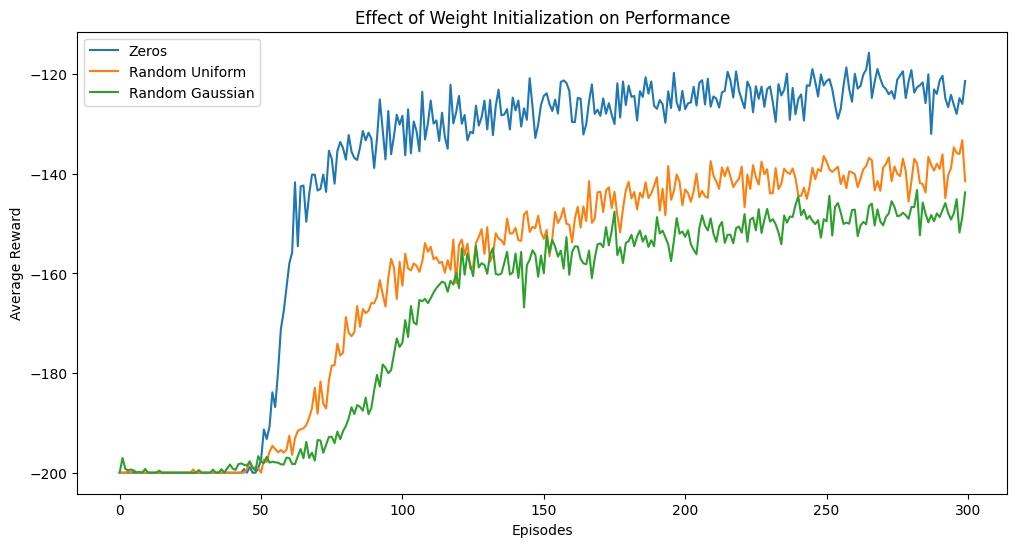

In [ ]:
# plot all results with error bars

mean_rewards_zeros = np.mean(rewards_zeros, axis=0)
std_rewards_zeros = np.std(rewards_zeros, axis=0)
mean_rewards_random_uniform = np.mean(rewards_random_uniform, axis=0)
std_rewards_random_uniform = np.std(rewards_random_uniform, axis=0)
mean_rewards_random_gaussian = np.mean(rewards_random_gaussian, axis=0)


plt.figure(figsize=(12, 6))
plt.title("Effect of Weight Initialization on Performance")
plt.plot(np.mean(rewards_zeros, axis=0), label="Zeros")
plt.plot(np.mean(rewards_random_uniform, axis=0), label="Random Uniform")
plt.plot(np.mean(rewards_random_gaussian, axis=0), label="Random Gaussian")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.legend()
plt.savefig("figs/2e2_weight_initialization_50.png")
plt.show()





Starting training for combination 1/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'expl_strategy': 'e-greedy'}


100%|██████████| 500/500 [00:06<00:00, 77.85it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 163.22it/s]


Policy achieves an average total reward of -126.8 +/- 7.6 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'expl_strategy': 'boltzmann'}


100%|██████████| 500/500 [00:11<00:00, 45.19it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 104.43it/s]


Policy achieves an average total reward of -121.6 +/- 5.4 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'λ': 0.6, 'gamma': 1, 'epsilon': 0.1, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction factor': 0.7, 'initialization': 'zeros', 'type_coeffs': 'nothing', 'defined_coeffs': array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2]]), 'expl_strategy': 'worst'}


100%|██████████| 500/500 [00:06<00:00, 75.15it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 140.34it/s]


Policy achieves an average total reward of -128.1 +/- 7.7 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 3 completed!


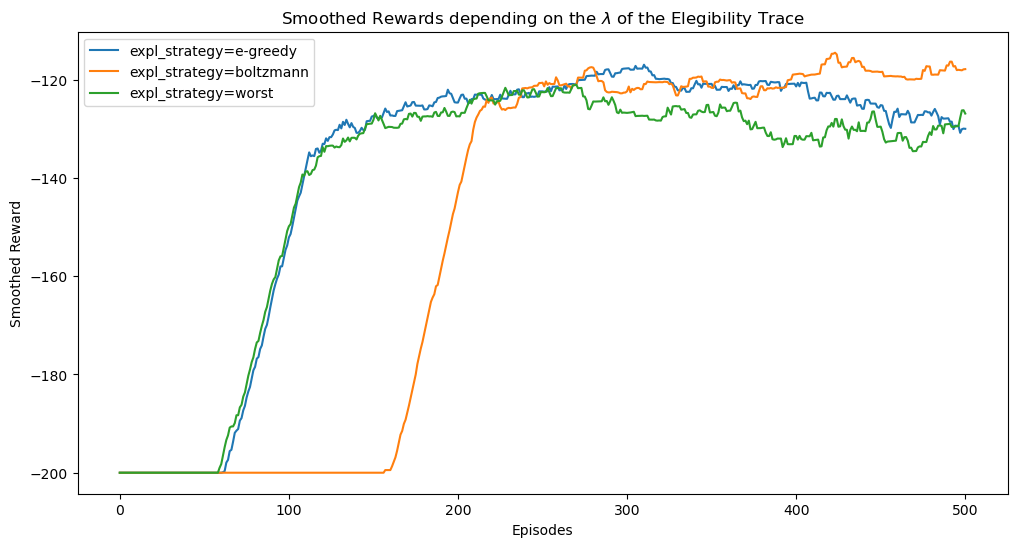

In [34]:


if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "λ":  0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.1,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction factor": 0.7,  # LR reduction factor (fixed)
        "initialization": "zeros", # Weight initialization
        "expl_strategy": ["e-greedy", "boltzmann", "worst"],
        "type_coeffs": "nothing", 
        "defined_coeffs":  predefined_coeff_matrix_5,
    }

    # Run the hyperparameter search
    all_rewards, all_labels, test_avg_rewards, test_confidences = run_hyperparameter_search(hyperparameters, num_episodes=500, test_episodes=50)
   
    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=False)
    #plot_test_results(test_avg_rewards, test_confidences, [1, 0.8, 0.6, 0.4, 0])


In [22]:
#### 3D PLOTS --> CAL ARRGLAR CODI (FALTA DEFINIR HYPERPARAMETRES PER PODER-HO EXECUTAR)

In [ ]:
def plot_policy(position_grid, velocity_grid, optimal_policy):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(position_grid, velocity_grid, optimal_policy, cmap='coolwarm')
    ax.set_title("Optimal Policy")
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("Action")
    plt.show()


def plot_v_function(position_grid, velocity_grid, v_values):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(position_grid, velocity_grid, value_function, cmap='viridis')
    ax.set_title("Value Function")
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("Value")
    plt.show()



if __name__ == "__main__":
    # Initialize environment
    env = gym.make('MountainCar-v0')
    
    # Set hyperparameters for SARSA(λ)
    state_space = env.observation_space
    action_space = env.action_space
    alpha = 0.001  # Learning rate
    lamb = 0.6  # λ value for eligibility traces
    gamma = 0.99  # Discount factor
    epsilon = 0.1  # Exploration probability
    fourier_order = 2  # Fourier order
    max_non_zero_fourier = 2  # Max non-zero Fourier coefficients

    
    
    # Initialize SARSA(λ) agent
    agent = SarsaLambda(
        state_space=state_space,
        action_space=action_space,
        alpha=alpha,
        lamb=lamb,
        gamma=gamma,
        epsilon=epsilon,
        fourier_order=fourier_order,
        max_non_zero_fourier=max_non_zero_fourier
    )
    
    # Initialize trainer
    trainer = Trainer(
        environment=env,
        agent=agent,
        epsilon=epsilon,
        number_episodes=500,  # Number of episodes to train
        episode_reward_trigger=-150,  # Reward threshold for early stopping
        early_stopping=True  # Enable early stopping
    )
    
    # Train the agent
    print("Starting training...")
    trainer.train()
    print("Training completed!")
    trainer.test(N=50, verbose=True)
    print("Testing completed!")
    
    # Plot training results
    plt.plot(trainer.episode_reward_list)
    plt.title("Episode Rewards Over Time")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.show()


    # Plot the value function
    position_grid, velocity_grid, v_values = agent.get_v_function()
    plot_v_function(position_grid, velocity_grid, v_values)

    # Plot the optimal policy 
    position_grid, velocity_grid, optimal_policy = agent.get_policy()
    plot_policy(position_grid, velocity_grid, optimal_policy)

    env.close()

In [ ]:
### exploration strategies

Starting training for combination 1/3: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.3, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy'}


100%|██████████| 500/500 [00:06<00:00, 77.54it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 156.44it/s]


Policy achieves an average total reward of -128.7 +/- 8.2 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.3, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'boltzmann'}


100%|██████████| 500/500 [00:06<00:00, 75.79it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 164.04it/s]


Policy achieves an average total reward of -126.3 +/- 7.5 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.3, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'worst'}


100%|██████████| 500/500 [00:06<00:00, 74.93it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 152.33it/s]


Policy achieves an average total reward of -123.7 +/- 6.8 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!


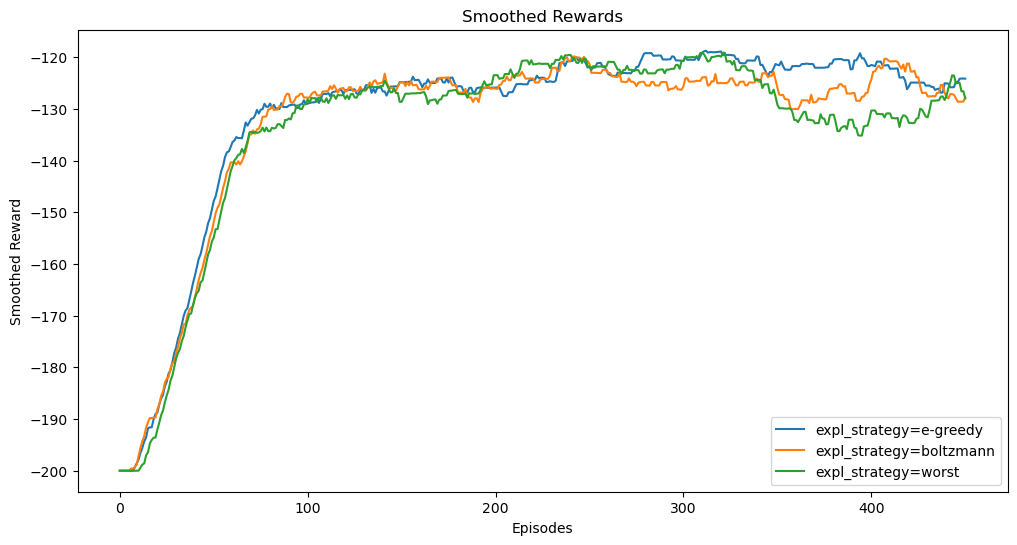

In [26]:
if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "lamb": 0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.3,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction_factor": 0.7,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": ["e-greedy", "boltzmann", "worst"]
    }

    # Run the hyperparameter search
    all_rewards, all_labels = run_hyperparameter_search(hyperparameters, num_episodes=500, test_episodes=50)

    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=False)


Starting training for combination 1/3: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.9, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy'}


100%|██████████| 250/250 [00:03<00:00, 66.37it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 184.26it/s]


Policy achieves an average total reward of -116.7 +/- 3.1 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.9, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'boltzmann'}


100%|██████████| 250/250 [00:06<00:00, 36.77it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 108.27it/s]


Policy achieves an average total reward of -117.4 +/- 4.7 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.9, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'worst'}


100%|██████████| 250/250 [00:04<00:00, 62.39it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 166.47it/s]


Policy achieves an average total reward of -114.8 +/- 3.3 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!


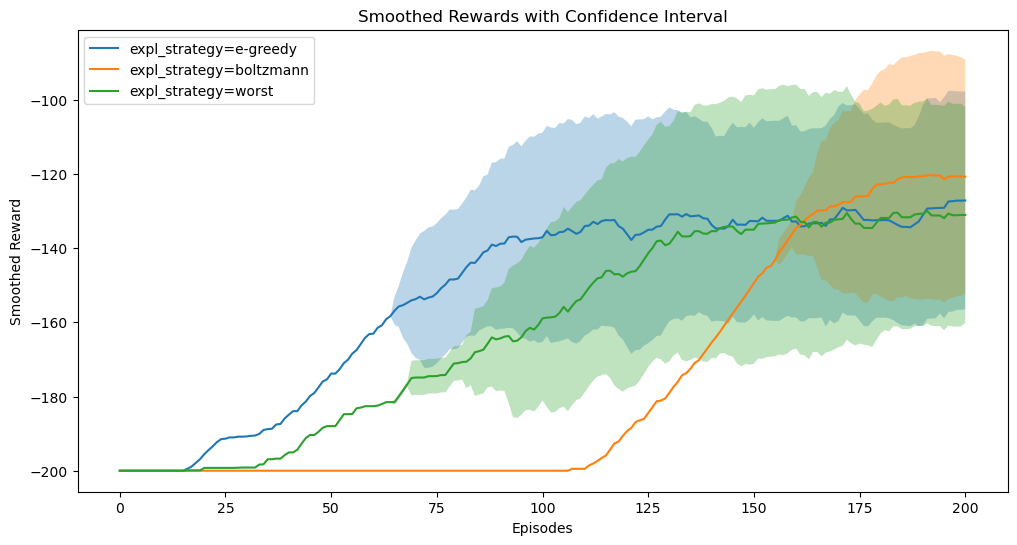

In [65]:
if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "lamb": 0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.9,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction_factor": 0.7,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": ["e-greedy", "boltzmann", "worst"]
    }

    # Run the hyperparameter search
    all_rewards, all_labels = run_hyperparameter_search(hyperparameters, num_episodes=250, test_episodes=50)

    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=True)


Starting training for combination 1/3: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.9, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'e-greedy'}


100%|██████████| 250/250 [00:03<00:00, 65.26it/s]


Training for combination 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 179.19it/s]


Policy achieves an average total reward of -115.2 +/- 3.8 with confidence 95%.
Your policy passed the test!
Testing for combination 1 completed!
Starting training for combination 2/3: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.9, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'boltzmann'}


100%|██████████| 250/250 [00:06<00:00, 37.91it/s]


Training for combination 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 111.60it/s]


Policy achieves an average total reward of -119.1 +/- 5.2 with confidence 95%.
Your policy passed the test!
Testing for combination 2 completed!
Starting training for combination 3/3: {'alpha': 0.001, 'lamb': 0.6, 'gamma': 1, 'epsilon': 0.9, 'fourier_order': 2, 'max_non_zero_fourier': 2, 'reduction_factor': 0.7, 'initialization': 'zeros', 'expl_strategy': 'worst'}


100%|██████████| 250/250 [00:03<00:00, 63.84it/s]


Training for combination 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 192.07it/s]


Policy achieves an average total reward of -112.5 +/- 2.0 with confidence 95%.
Your policy passed the test!
Testing for combination 3 completed!


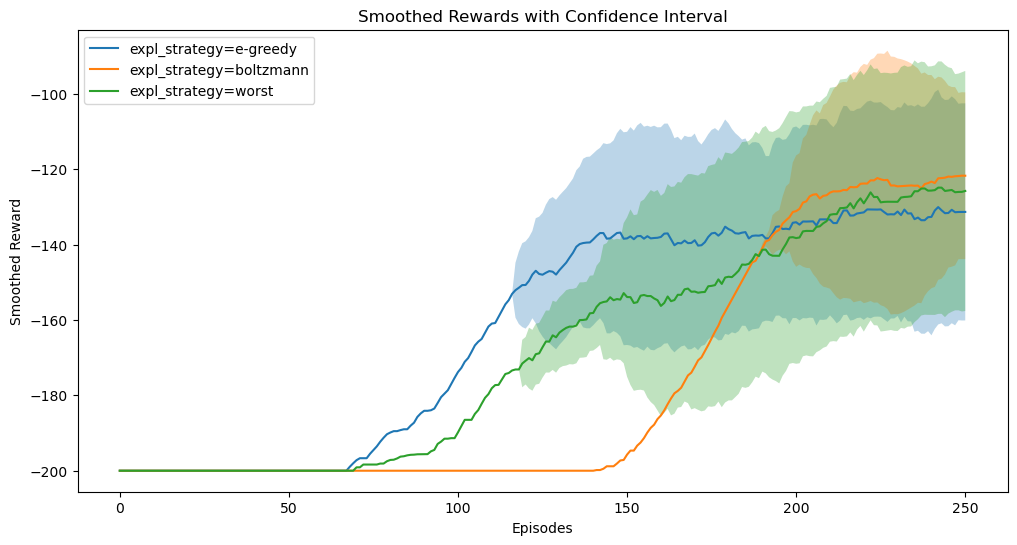

In [19]:
if __name__ == "__main__":
    # Define hyperparameters as a dictionary
    hyperparameters = {
        "alpha": 0.001,  # Learning rate
        "lamb": 0.6,      # λ for eligibility traces
        "gamma": 1,              # Discount factor (fixed)
        "epsilon": 0.9,          # Exploration probability (fixed)
        "fourier_order": 2,      # Fourier order (fixed)
        "max_non_zero_fourier": 2,  # Max non-zero Fourier coefficients (fixed)
        "reduction_factor": 0.7,  # LR reduction factor (fixed)
        "initialization": "zeros",  # Weight initialization
        "expl_strategy": ["e-greedy", "boltzmann", "worst"]
    }

    # Run the hyperparameter search
    all_rewards, all_labels = run_hyperparameter_search(hyperparameters, num_episodes=250, test_episodes=50)

    # Plot results
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=all_labels, cf=True)


In [24]:
### PLOT SOLUTION

Starting training...


100%|██████████| 200/200 [00:02<00:00, 68.19it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 173.86it/s]


Policy achieves an average total reward of -130.0 +/- 5.9 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing completed!


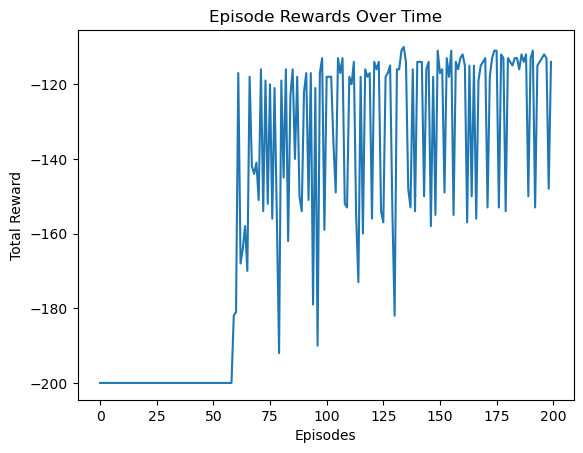

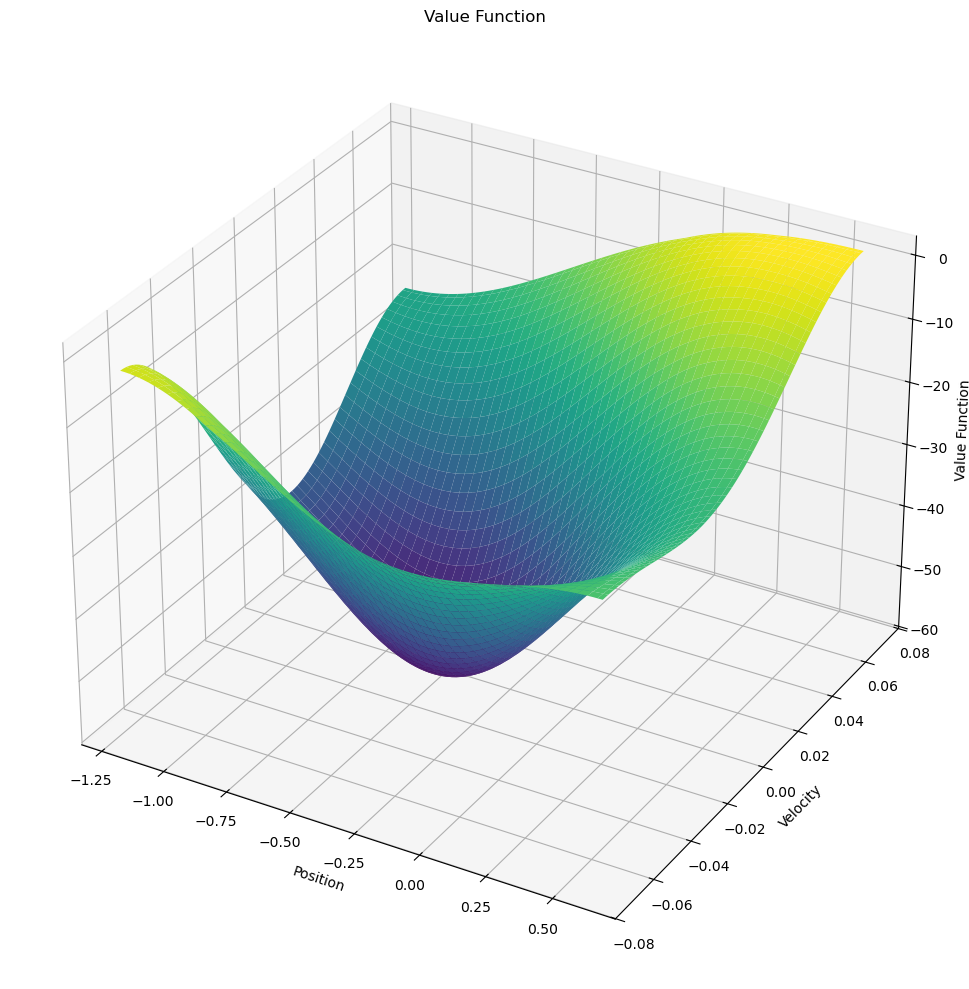

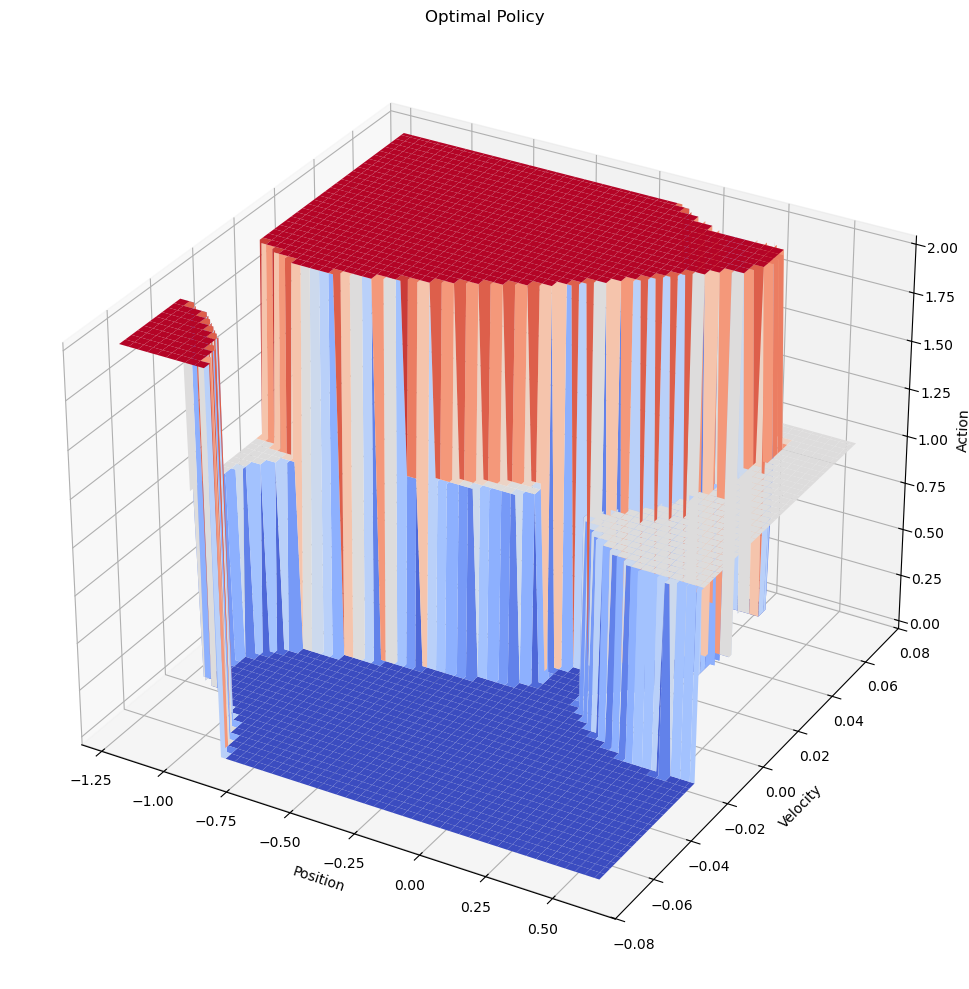

In [36]:
def plot_policy(position_grid, velocity_grid, optimal_policy):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(position_grid, velocity_grid, optimal_policy, cmap='coolwarm')
    ax.set_title("Optimal Policy")
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("Action")
        
    #fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10, label="Action Values")
    plt.tight_layout()

    plt.show()


def plot_v_function(position_grid, velocity_grid, v_values):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(position_grid, velocity_grid, v_values, cmap='viridis')
    ax.set_title("Value Function")
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("Value Function")

    #fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10, label="Value")
    plt.tight_layout()


    plt.show()



if __name__ == "__main__":
    # Initialize environment
    env = gym.make('MountainCar-v0')
    
    # Set hyperparameters for SARSA(λ)
    state_space = env.observation_space
    action_space = env.action_space
    alpha = 0.001  # Learning rate
    lamb = 0.6  # λ value for eligibility traces
    gamma = 1  # Discount factor
    epsilon = 0.3  # Exploration probability
    fourier_order = 2  # Fourier order
    max_non_zero_fourier = 2  # Max non-zero Fourier coefficients
    reduction_factor = 0.7
    initialization = "zeros"
    expl_strategy = "e-greedy"
    type_coeffs = "nothing"
    defined_coeffs = predefined_coeff_matrix_5
    num_episodes = 200
    early_stopping = False

    
    # Initialize SARSA(λ) agent
    agent = SarsaLambda(
        state_space=env.observation_space,
        action_space=env.action_space,
        alpha=alpha,
        lamb=lamb,
        gamma=gamma,
        epsilon=epsilon,
        fourier_order=fourier_order,
        max_non_zero_fourier=max_non_zero_fourier,
        reduction_factor=reduction_factor,
        initialization=initialization,
        expl_strategy=expl_strategy,
        type_coeffs=type_coeffs,
        defined_coeffs=defined_coeffs
    )

    # Initialize trainer
    trainer = Trainer(
        environment=env,
        agent=agent,
        epsilon=epsilon,
        number_episodes=num_episodes,
        episode_reward_trigger=-150,
        early_stopping=early_stopping,
    )
    
    # Train the agent
    print("Starting training...")
    trainer.train()
    print("Training completed!")
    trainer.test(N=50, verbose=True)
    print("Testing completed!")
    
    # Plot training results
    plt.plot(trainer.episode_reward_list)
    plt.title("Episode Rewards Over Time")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.show()


    # Plot the value function
    position_grid, velocity_grid, v_values = agent.get_v_function()
    plot_v_function(position_grid, velocity_grid, v_values)

    # Plot the optimal policy 
    position_grid, velocity_grid, optimal_policy = agent.get_policy()
    plot_policy(position_grid, velocity_grid, optimal_policy)

    env.close()